# Introduction to `geopandas`
---

Today we are going to learn how to use python and Jupyter notebooks to learn the basics of working with geospatial data in `geopandas`. `geopandas` is built on top of the `pandas` package you saw in the previous lab. Many of the methods you will see in this lab are shared between the two packages.

In [1]:
# This line tells iPython to not display warnings.
import warnings
warnings.filterwarnings('ignore')

# RUN THIS CELL FIRST or the notebook won't work
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import gtfs_kit as gk
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
from IPython.display import display
import matplotlib.pyplot as plt

# These help the maps display nicely in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 20]

First, let's load our data and see what kind of data we are working with.  The `read_file` method requires that we pass the _filepath_ from our current directory (the location of this notebook) to the data. The `pwd()` function shows you the your current location in the file system. Another way you can say this is that it __p__rints your __w__orking __d__irectory.

In [5]:
pwd()

'/accounts/gen/guest/hmoore/git/cp101.github.io/labs/lab10'

To get to the data, we would first enter the `lct_000b21a_e` folder from the working directory. The way we communicate this to the function is by passing `'lct_000b21a_e/lct_000b21a_e.shp'` as an argument. This folder contains geographic information organized by census tract for the entirety of Canada.

In [6]:
canada_shp = gpd.read_file('lct_000b21a_e/lct_000b21a_e.shp')

Let's take a look at what our data looks like in Jupyter. We can use the `.head()` method to show the first 5 rows of our data. Similarly, you can use the `.tail()` method to show the last 5 rows of the data.

In [7]:
canada_shp.head()

CTUID                DGUID   CTNAME  LANDAREA PRUID  \
0  5370001.08  2021S05075370001.08  0001.08    1.6383    35   
1  0010002.00  2021S05070010002.00  0002.00    1.9638    10   
2  5370001.09  2021S05075370001.09  0001.09    1.9699    35   
3  5370120.02  2021S05075370120.02  0120.02   76.9650    35   
4  0010006.00  2021S05070010006.00  0006.00    1.0467    10   

                                            geometry  
0  POLYGON ((7196507.366 869787.991, 7196501.617 ...  
1  POLYGON ((8980216.643 2151065.360, 8980377.609...  
2  POLYGON ((7196437.003 869160.246, 7196434.403 ...  
3  POLYGON ((7189475.703 865662.849, 7189448.943 ...  
4  POLYGON ((8980091.143 2152478.609, 8980100.254...

This is nice, but we'd like to have some data to go with these polygons, and we'd like to just work within the Census Metropolitan Area of Toronto. Let's load some data from an earlier lab.

In [8]:
toronto_cma = pd.read_csv("~/git/cp101.github.io/labs/lab10/census21_data.csv")

In [9]:
toronto_cma.columns

Index(['Unnamed: 0', 'GeoUID', 'Type', 'Region Name', 'Area (sq km)',
       'Population', 'Dwellings', 'Households', 'CMA_UID', 'PR_UID', 'CSD_UID',
       'CD_UID',
       'v_CA21_1040: Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
       'v_CA21_1043: 0 to 17 years', 'v_CA21_1046: 0 to 5 years',
       'v_CA21_1049: 18 to 64 years', 'v_CA21_1052: 65 years and over',
       'v_CA21_1085: Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)',
       'v_CA21_1088: 0 to 17 years', 'v_CA21_1091: 0 to 5 years',
       'v_CA21_1094: 18 to 64 years', 'v_CA21_1097: 65 years and over',
       'v_CA21_1140: Gini index on adjusted household total income',
       'v_CA21_1141: Gini index on adjusted household market income',
       'v_CA21_1142: Gini index on adjusted household after-tax income',
       'v_CA21_8: Total - Age', 'v_CA21_251: 65 years and over',
       'v_CA21_386: Average age', 'v_CA21_389: Average age'],
      dt

## Important

Many times over the course of reading and writing data from external sources, you might find that data types become corrupted. We can see that the GeoUID field in this dataframe ought to be right padded with zeroes so that it can match the expected form of the census tract ID in the geometry shapefile. Let's take care of that right away.

In [10]:
# fix missingness and data types
toronto_cma = toronto_cma.fillna(0)
toronto_cma = toronto_cma.replace({'NA': 0})
toronto_cma = toronto_cma.replace({'': 0})
toronto_cma.iloc[:,4:] = toronto_cma.iloc[:,4:].apply(pd.to_numeric)
# pad to get correct geouid length
toronto_cma["GeoUID"] = toronto_cma["GeoUID"].astype(str).str.ljust(10, "0")

In [11]:
toronto_cma.head()

Unnamed: 0      GeoUID Type  Region Name  Area (sq km)  Population  \
0           1  5350001.00   CT          1.0        6.8192         599   
1           2  5350002.00   CT          2.0        3.3926         604   
2           3  5350003.00   CT          3.0        0.9455         457   
3           4  5350004.00   CT          4.0        0.3404        6306   
4           5  5350005.00   CT          5.0        0.3764        6957   

   Dwellings  Households  CMA_UID  PR_UID  ...  v_CA21_1091: 0 to 5 years  \
0        253         235    35535     0.0  ...                        0.0   
1        294         284    35535     0.0  ...                        0.0   
2        279         265    35535     0.0  ...                        0.0   
3       3620        3276    35535     0.0  ...                        8.0   
4       4235        3720    35535     0.0  ...                        7.0   

   v_CA21_1094: 18 to 64 years  v_CA21_1097: 65 years and over  \
0                          6.0                             8.0   
1                         11.0                             7.0   
2                          8.0                             0.0   
3                         16.2                            10.8   
4                         13.0                            14.2   

   v_CA21_1140: Gini index on adjusted household total income  \
0                                              0.360            
1                                              0.346            
2                                              0.370            
3                                              0.358            
4                                              0.380            

   v_CA21_1141: Gini index on adjusted household market income  \
0                                              0.426             
1                                              0.460             
2                                              0.446             
3                                              0.544             
4                                              0.513             

   v_CA21_1142: Gini index on adjusted household after-tax income  \
0                                              0.309                
1                                              0.301                
2                                              0.322                
3                                              0.314                
4                                              0.334                

   v_CA21_8: Total - Age  v_CA21_251: 65 years and over  \
0                  600.0                           55.0   
1                  605.0                          250.0   
2                  460.0                           45.0   
3                 6310.0                          840.0   
4                 6950.0                          865.0   

   v_CA21_386: Average age  v_CA21_389: Average age  
0                     38.9                     40.4  
1                     55.0                     62.0  
2                     39.6                     38.0  
3                     41.8                     40.0  
4                     39.9                     36.4  

[5 rows x 29 columns]

Much better. Now, let's do a left inner join to the GeoPandas dataframes so that the resulting object will retain its geometric properties.

In [12]:
toronto_gpd = canada_shp.merge(toronto_cma, how = "inner", left_on = "CTUID", right_on = "GeoUID")
toronto_gpd.head()

CTUID                DGUID   CTNAME  LANDAREA PRUID  \
0  5350420.13  2021S05075350420.13  0420.13    1.8675    35   
1  5350422.03  2021S05075350422.03  0422.03    3.5903    35   
2  5350422.04  2021S05075350422.04  0422.04    0.8388    35   
3  5350422.05  2021S05075350422.05  0422.05    1.5519    35   
4  5350422.06  2021S05075350422.06  0422.06    1.8382    35   

                                            geometry  Unnamed: 0      GeoUID  \
0  POLYGON ((7218613.794 949619.114, 7218679.703 ...         706  5350420.13   
1  POLYGON ((7219855.811 954804.291, 7219916.443 ...         715  5350422.03   
2  POLYGON ((7217958.140 954705.514, 7217957.497 ...         716  5350422.04   
3  POLYGON ((7216908.840 954698.554, 7216912.983 ...         717  5350422.05   
4  POLYGON ((7215728.211 952217.103, 7215620.917 ...         718  5350422.06   

  Type  Region Name  ...  v_CA21_1091: 0 to 5 years  \
0   CT       420.13  ...                        6.0   
1   CT       422.03  ...                        6.0   
2   CT       422.04  ...                        8.0   
3   CT       422.05  ...                       12.0   
4   CT       422.06  ...                       13.0   

   v_CA21_1094: 18 to 64 years  v_CA21_1097: 65 years and over  \
0                          8.4                            13.0   
1                          5.4                             5.0   
2                          6.5                             5.2   
3                          7.4                             4.4   
4                         11.8                             8.0   

   v_CA21_1140: Gini index on adjusted household total income  \
0                                              0.360            
1                                              0.323            
2                                              0.350            
3                                              0.344            
4                                              0.363            

   v_CA21_1141: Gini index on adjusted household market income  \
0                                              0.462             
1                                              0.414             
2                                              0.441             
3                                              0.433             
4                                              0.545             

   v_CA21_1142: Gini index on adjusted household after-tax income  \
0                                              0.316                
1                                              0.283                
2                                              0.313                
3                                              0.302                
4                                              0.320                

   v_CA21_8: Total - Age  v_CA21_251: 65 years and over  \
0                 6205.0                          985.0   
1                 6810.0                          825.0   
2                 3760.0                          545.0   
3                 6730.0                          895.0   
4                 5355.0                         1280.0   

   v_CA21_386: Average age  v_CA21_389: Average age  
0                     41.9                     41.2  
1                     39.6                     42.0  
2                     41.4                     45.2  
3                     41.2                     45.6  
4                     45.0                     46.0  

[5 rows x 35 columns]

## Examining the data 

### Accessing the data <font color='red'> 

The `.loc[]` and `.iloc[]` methods allow us to view cells in a `DataFrame` or `GeoDataFrame` based on their name or location. The __i__ in `.iloc[]` stands for the __integer__ position of a cell, and accesses cells by location in index coordinates. The `.loc[]` method allows you to access cells by the index of the rows and the names of the columns. For both `.loc[]` and `.iloc[]`, the first argument refers to the row, and the second argument refers to the column.

Typically the row index will be the same as its integer position, but that is not always the case. Let's set up a `DataFrame` to see this in action.

In [13]:
df = pd.DataFrame(data = {'a': [1, 2, 3],
                         'b': [4, 5, 6],
                         'c': [7, 8, 9],
                         'd': [10, 11, 12]},
                 index = [1.1, 1.2, 1.3])
df

a  b  c   d
1.1  1  4  7  10
1.2  2  5  8  11
1.3  3  6  9  12

If we want to access the number 8 from `df`, we would need to tell `.iloc[]` to look in `df` at row `1`, column `2` (remember that python starts counting from zero!).

In [14]:
df.iloc[1, 2]

8

Using `.loc[]`, we would need to tell the method that we want row index `1.2`, column name `'c'`.

In [15]:
df.loc[1.2, 'c']

8

You can also specify a range of indices to both of these methods if you want to access multiple adjacent cells. For `iloc[]`, this range will always refer to integer coordinates of the cells.

In [16]:
# This code tells .iloc that we want rows 0 and 2, then all columns with index
# greater than or equal to 1.
df.iloc[[0, 2], 1:]

b  c   d
1.1  4  7  10
1.3  6  9  12

We can also refer to a range named columns and rows using `.loc[]`

In [17]:
# This code tells .loc that we want row 1.2, columns 'b' through 'd' inclusive.
df.loc[[1.2], 'b':'d']

b  c   d
1.2  5  8  11

### Basic maps <font color='red'>

The `geometry` column contains a new data type called a polygon, which is how `geopandas` is able to store geographic information. Let's look at one of these polygons using `.loc[]`.

Is this a part of Toronto you recognize? Perhaps on a large park on the lakefront?

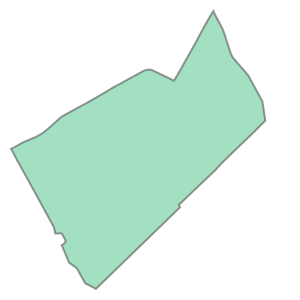

In [18]:
toronto_gpd.loc[7, 'geometry']

Or perhaps this warped rectangle? A familiar university campus, near an urban park? 

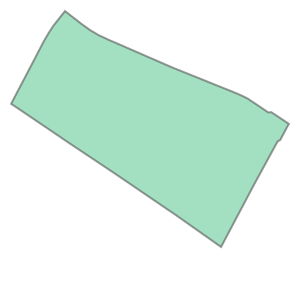

In [19]:
toronto_gpd.loc[55, 'geometry']

To view all of the polygons in the `GeoDataFrame`, we can just use the `.plot()` method. The documentation for this function can be found [here](http://geopandas.org/mapping.html).

<AxesSubplot: >

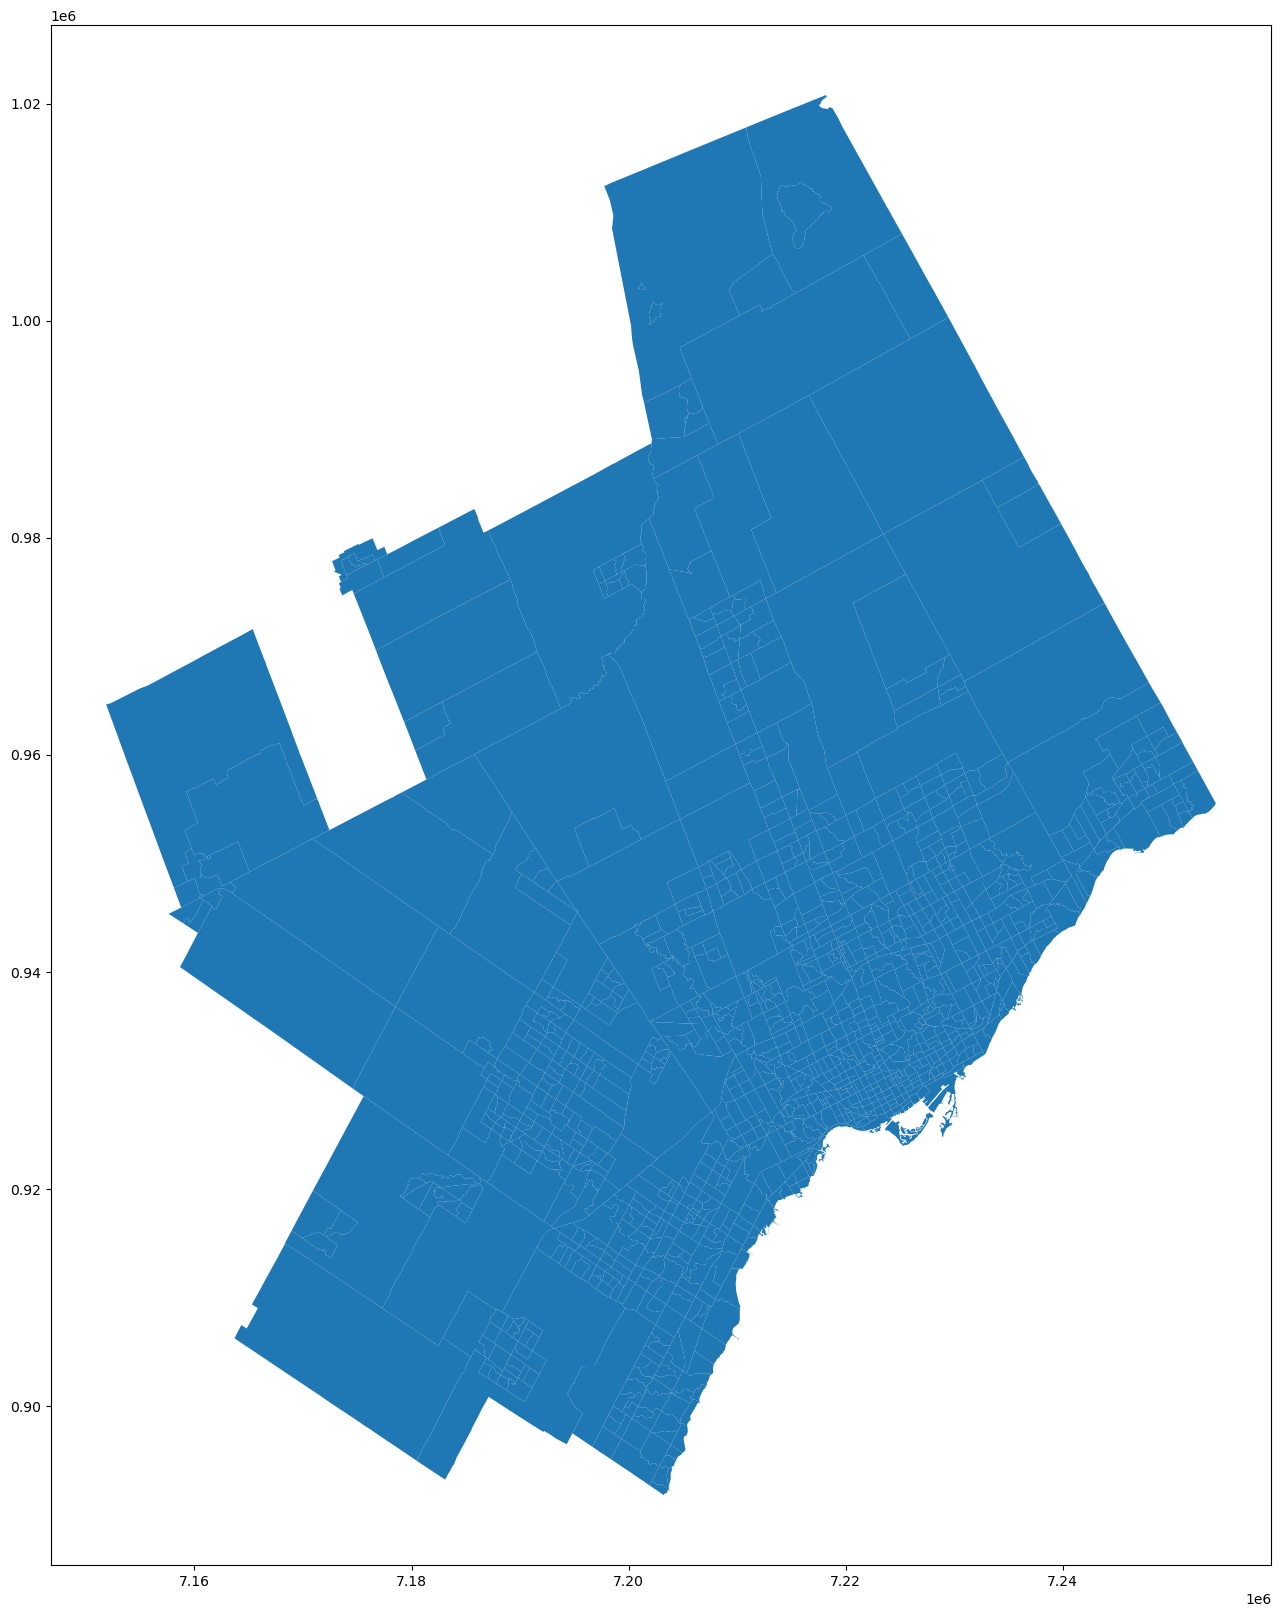

In [20]:
toronto_gpd.plot()

You can improve the appearance of this graph by removing the axis labels surrounding the map and adding a title. You may also see a line that says something like `<matplotlib.axes._subplots.AxesSubplot at [hexadecimal]>` above the map. You can prevent Jupyter from displaying this line by adding a `;` to the last line of code creating the map.

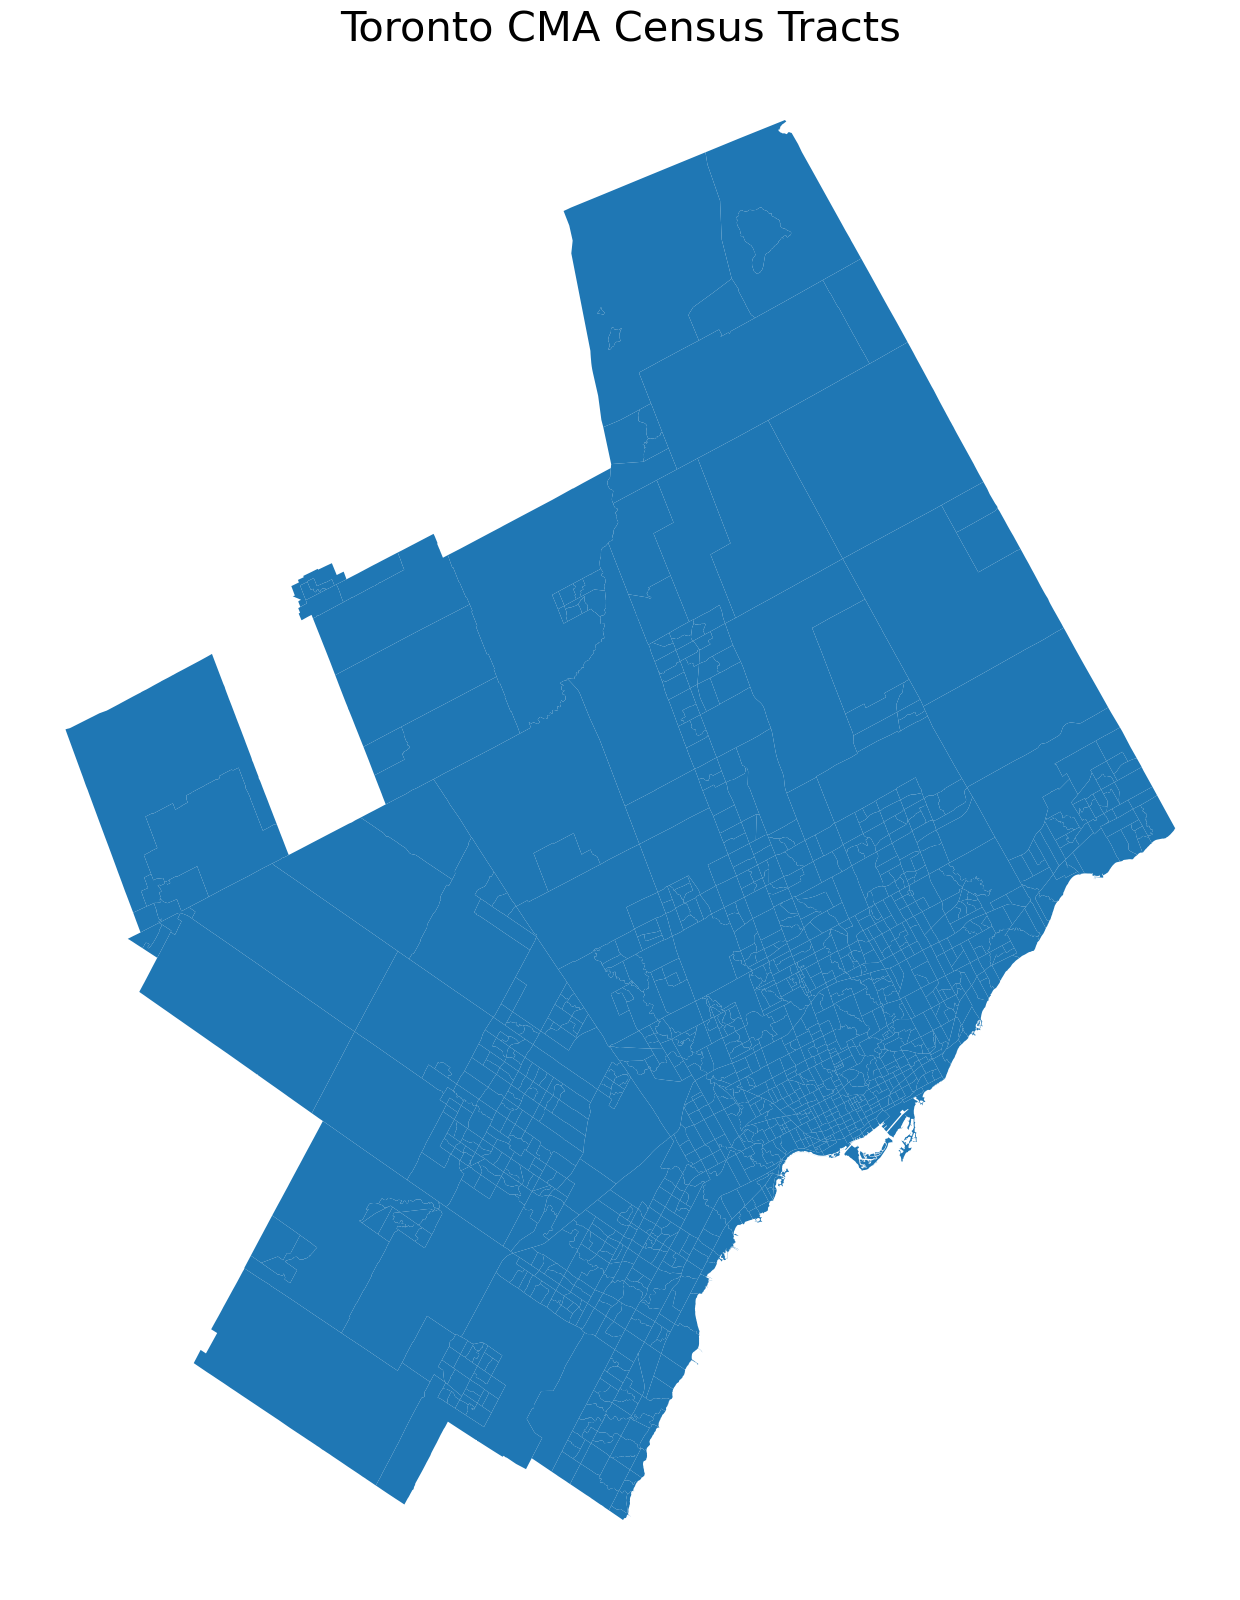

In [21]:
toronto_gpd.plot()

# Adding the fontsize argument allows you to manipulate the font size.
plt.title('Toronto CMA Census Tracts', fontsize = 30)

# This turns the plot axes off.
plt.axis('off');

# Creating a new shapefile
    
These are nice maps, but there are ways to make it more informative. For starters, the Toronto CMA is quite a large area with a high amount of variance in census tract area. This does not make for the most visually pleasing map, so for now let's continue on a previous theme and focus just on the City of Toronto. 
    
We can do this by performing an inner join on the GeoUIDs of census tracts we queried in previous labs. 

In [22]:
toronto_csd = pd.read_csv('~/git/cp101.github.io/labs/lab03/census21_data.csv')
# fix missingness and data types
toronto_csd = toronto_csd.fillna(0)
toronto_csd = toronto_csd.replace({'NA': 0})
toronto_csd = toronto_csd.replace({'': 0})
# create toronto census tracts from this column
toronto_census_tracts = toronto_csd["GeoUID"] 

In [23]:
# a familiar number of census tracts!
toronto_census_tracts.shape

(585,)

Let's try something a little different from our previous method of changing GeoUIDs to strings- a list comprehension. 

In [24]:
toronto_census_tracts_str = [str(x).ljust(10, "0") for x in toronto_census_tracts]

If we were going to write this list comprehension as a for loop, we would have to create a new list to save our converted data into. It would look a little something like this:
```
toronto_census_tracts_str = []
for x in toronto_census_tracts:
    toronto_census_tracts_str.append(str(x).ljust(10, "0"))
```
List comprehensions are so much more efficient!

Next, we are going to use `isin` to subset the rows of `toronto_gpd` to just the rows belonging to City of Toronto census tracts and create a new `GeoDataFrame`.

In [141]:
# Create a new GeoDataFrame
toronto = toronto_gpd[toronto_gpd['GeoUID'].isin(toronto_census_tracts_str)]

In [26]:
# this should be True
toronto.shape[0] == len(toronto_census_tracts)

True

Next, we can save our new `GeoDataFrame`. The following code saves `toronto` as a file type called a "shapefile," which happens to be the same file type as the data we read in earlier. `geopandas` can also read and write many other geospatial file types, but we are just going to be using the same file type as before for now.

In [27]:
toronto.to_file(driver='ESRI Shapefile', filename = 'shapefiles/toronto')

Now, we've been working with lengthy variable names for the last few labs. Let's use dictionaries to create some more user-friendly variables to type without having to sacrifice on well-formatted descriptions. One thing to make note of is that there is a typo in the CensusMapper API and that the vector `v_CA21_389: Average age` should really be `v_CA21_389: Median age`. APIs can be very useful, but always [check again](https://censusmapper.ca/api#api_variable) if something looks unusual.

In [28]:
toronto.columns

Index(['CTUID', 'DGUID', 'CTNAME', 'LANDAREA', 'PRUID', 'geometry',
       'Unnamed: 0', 'GeoUID', 'Type', 'Region Name', 'Area (sq km)',
       'Population', 'Dwellings', 'Households', 'CMA_UID', 'PR_UID', 'CSD_UID',
       'CD_UID',
       'v_CA21_1040: Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
       'v_CA21_1043: 0 to 17 years', 'v_CA21_1046: 0 to 5 years',
       'v_CA21_1049: 18 to 64 years', 'v_CA21_1052: 65 years and over',
       'v_CA21_1085: Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)',
       'v_CA21_1088: 0 to 17 years', 'v_CA21_1091: 0 to 5 years',
       'v_CA21_1094: 18 to 64 years', 'v_CA21_1097: 65 years and over',
       'v_CA21_1140: Gini index on adjusted household total income',
       'v_CA21_1141: Gini index on adjusted household market income',
       'v_CA21_1142: Gini index on adjusted household after-tax income',
       'v_CA21_8: Total - Age', 'v_CA21_251: 65 years and over',
  

In [34]:
var_transforms = {'v_CA21_389: Average age':'medianage', 
                  'v_CA21_251: 65 years and over':'seniors',
                  'v_CA21_8: Total - Age':'tot_age',
                  'v_CA21_1040: Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)':'lim_at',
                  'v_CA21_1085: Prevalence of low income based on the Low-income cut-offs, after tax (LICO-AT) (%)':'lico_at',
                  'v_CA21_1140: Gini index on adjusted household total income':'gini_total',
                  'v_CA21_1141: Gini index on adjusted household market income':'gini_market',
                  'v_CA21_1142: Gini index on adjusted household after-tax income':'gini_after_tax'
                 }

toronto = toronto.rename(columns = var_transforms)

toronto['pct_seniors'] = toronto['seniors'] / toronto['tot_age']

plot_titles = {'medianage':'Median age by census tract', 
               'pct_seniors':'Percent of population 65 years and over by census tract',
               'lim_at':'Prevalence of low income based on the LIM-AT (%) by census tract',
               'lico_at':'Prevalence of low income based on the LICO-AT (%) by census tract',
               'gini_total':'Gini index on adjusted household total income by census tract',
               'gini_market':'Gini index on adjusted household market income by census tract',
               'gini_after_tax':'Gini index on adjusted household after-tax income by census tract'
                 }

In [35]:
toronto.columns

Index(['CTUID', 'DGUID', 'CTNAME', 'LANDAREA', 'PRUID', 'geometry',
       'Unnamed: 0', 'GeoUID', 'Type', 'Region Name', 'Area (sq km)',
       'Population', 'Dwellings', 'Households', 'CMA_UID', 'PR_UID', 'CSD_UID',
       'CD_UID', 'lim_at', 'v_CA21_1043: 0 to 17 years',
       'v_CA21_1046: 0 to 5 years', 'v_CA21_1049: 18 to 64 years',
       'v_CA21_1052: 65 years and over', 'lico_at',
       'v_CA21_1088: 0 to 17 years', 'v_CA21_1091: 0 to 5 years',
       'v_CA21_1094: 18 to 64 years', 'v_CA21_1097: 65 years and over',
       'gini_total', 'gini_market', 'gini_after_tax', 'tot_age', 'seniors',
       'v_CA21_386: Average age', 'medianage', 'pct_seniors'],
      dtype='object')

Now we can make a map with our new data. In fact, we can make a lot of maps with our new data. So let's make a function to avoid rewriting the same code over and over.

In [42]:
def simple_plot(plot_var):
    toronto.plot(column = plot_var, legend = True)
    plt.title(plot_titles[plot_var], fontsize = 30)
    plt.axis('off');

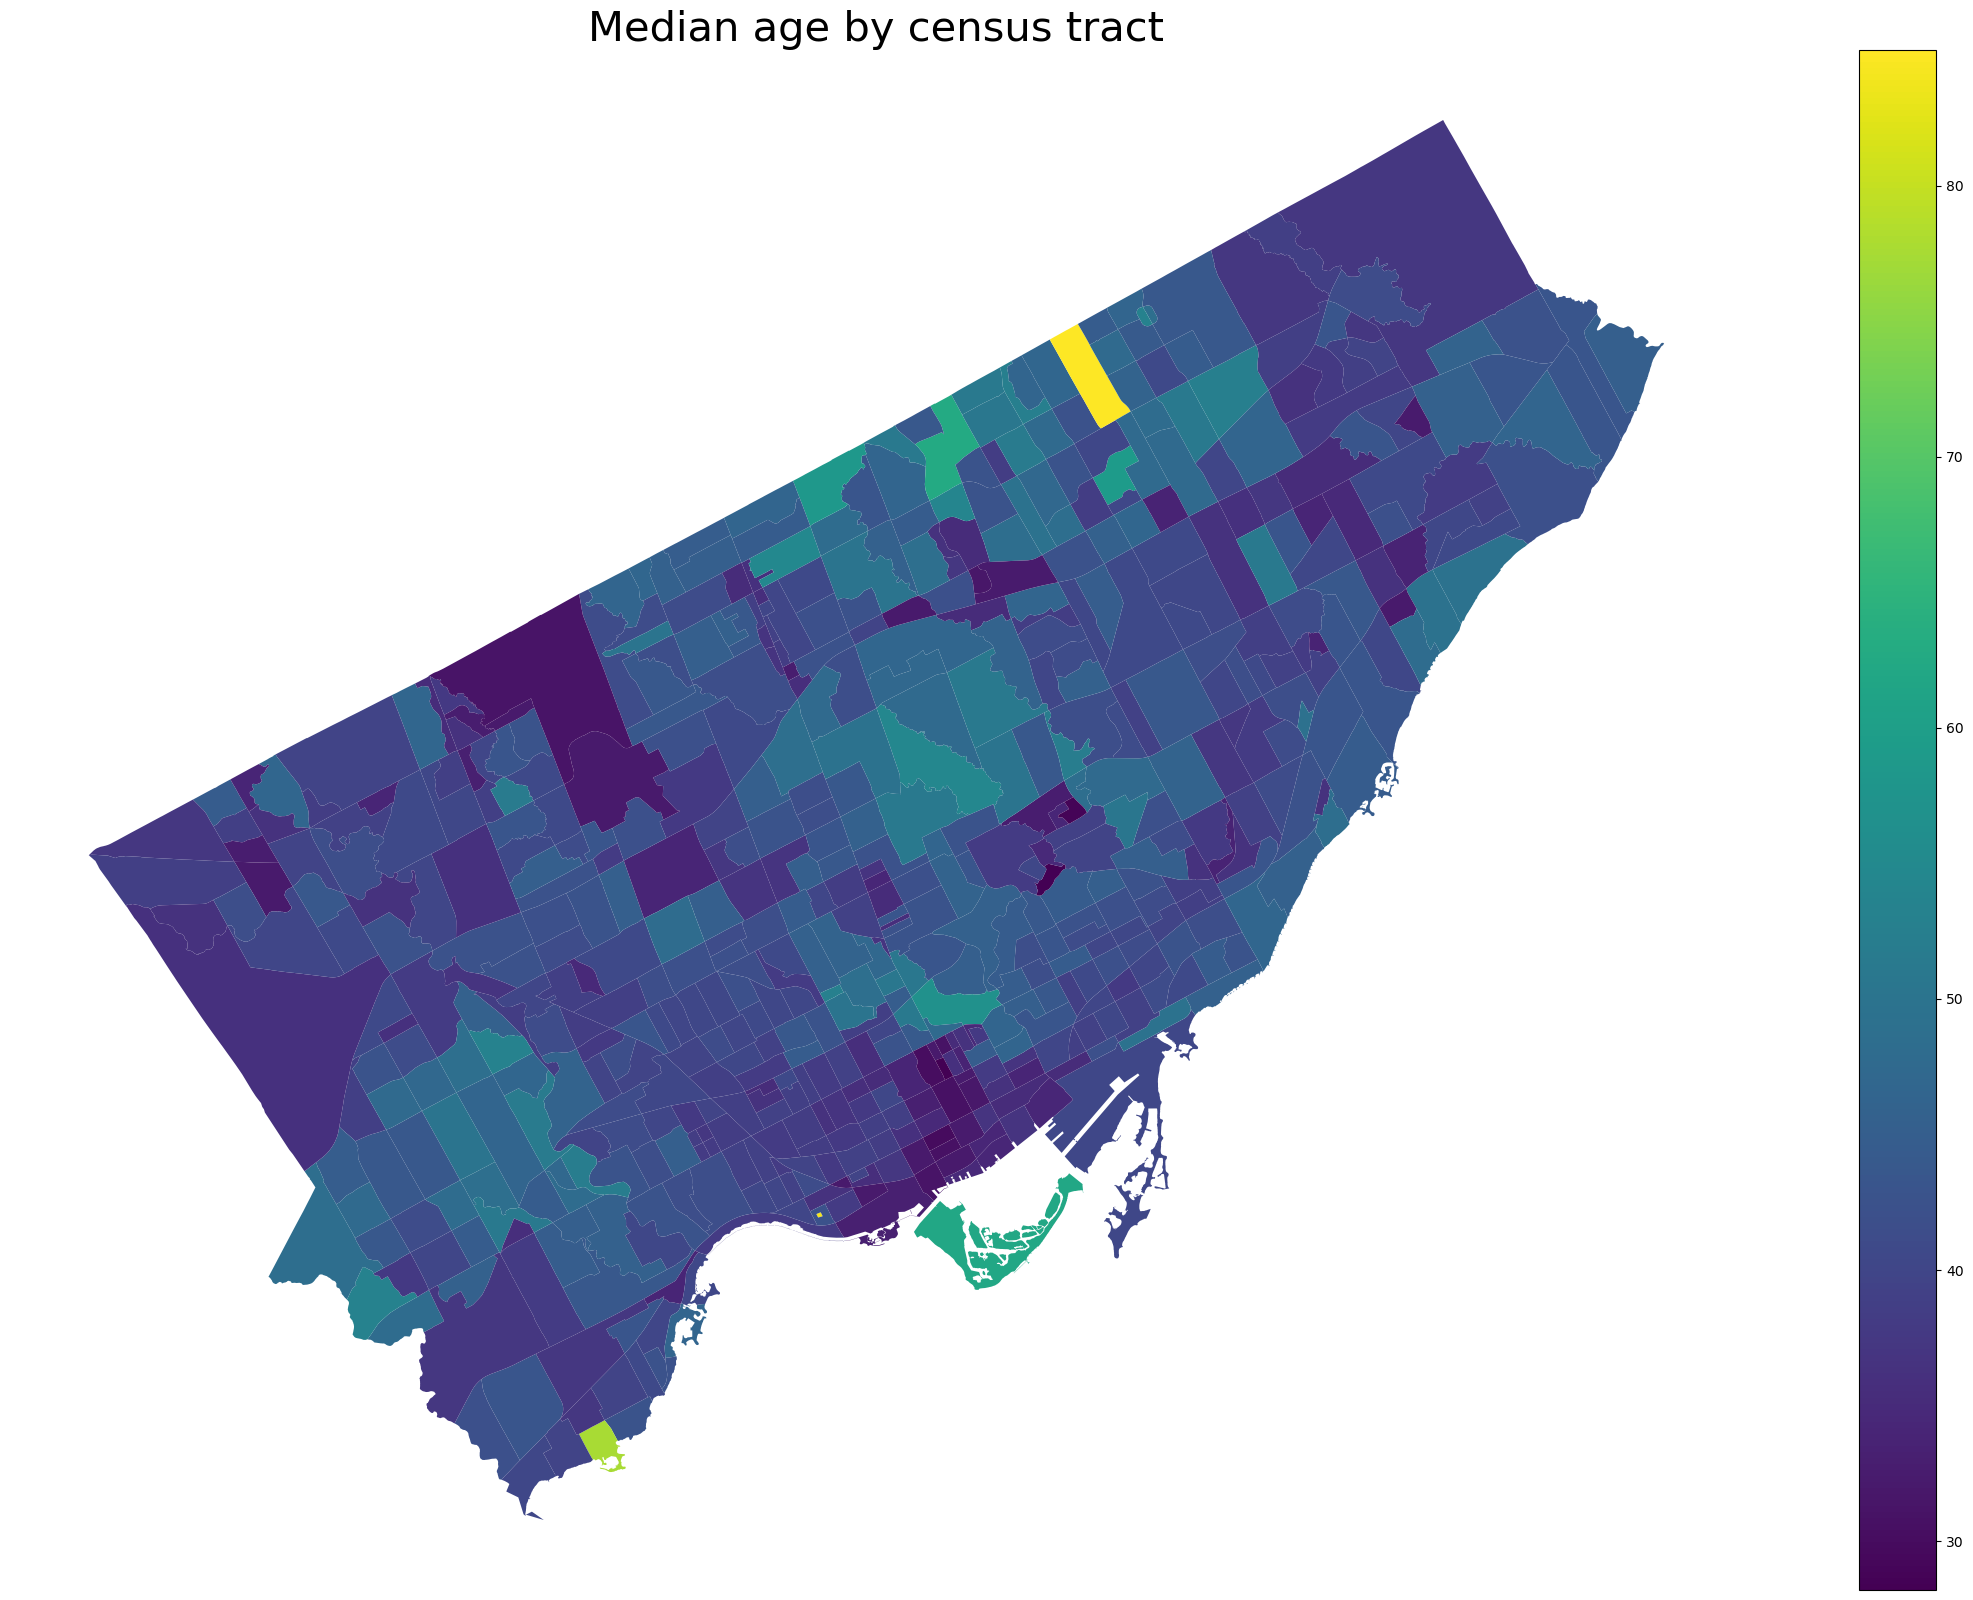

In [43]:
simple_plot('medianage')

Can you tell which census tracts are likely to be near the University of Toronto campus, just from looking at this map? If yes, why might that be? If no, what other information would you need in order to do so?

YOUR ANSWER HERE

If we want to make this map more informative, we can incorporate some of the other columns from the data into the map. For example, the `v_CA21_1142` vector contains [Gini index](https://www.physics.ucla.edu/~chester/GINI/index.html) of each census tract.

We can pass the column name as an optional argument to the `.plot()` method to create a map with a color gradient based on the values in this column. Setting `legend` equal to `True` in the function call will also tell the method that we want our final plot to have a legend so that we can interpret the colors on the map. 

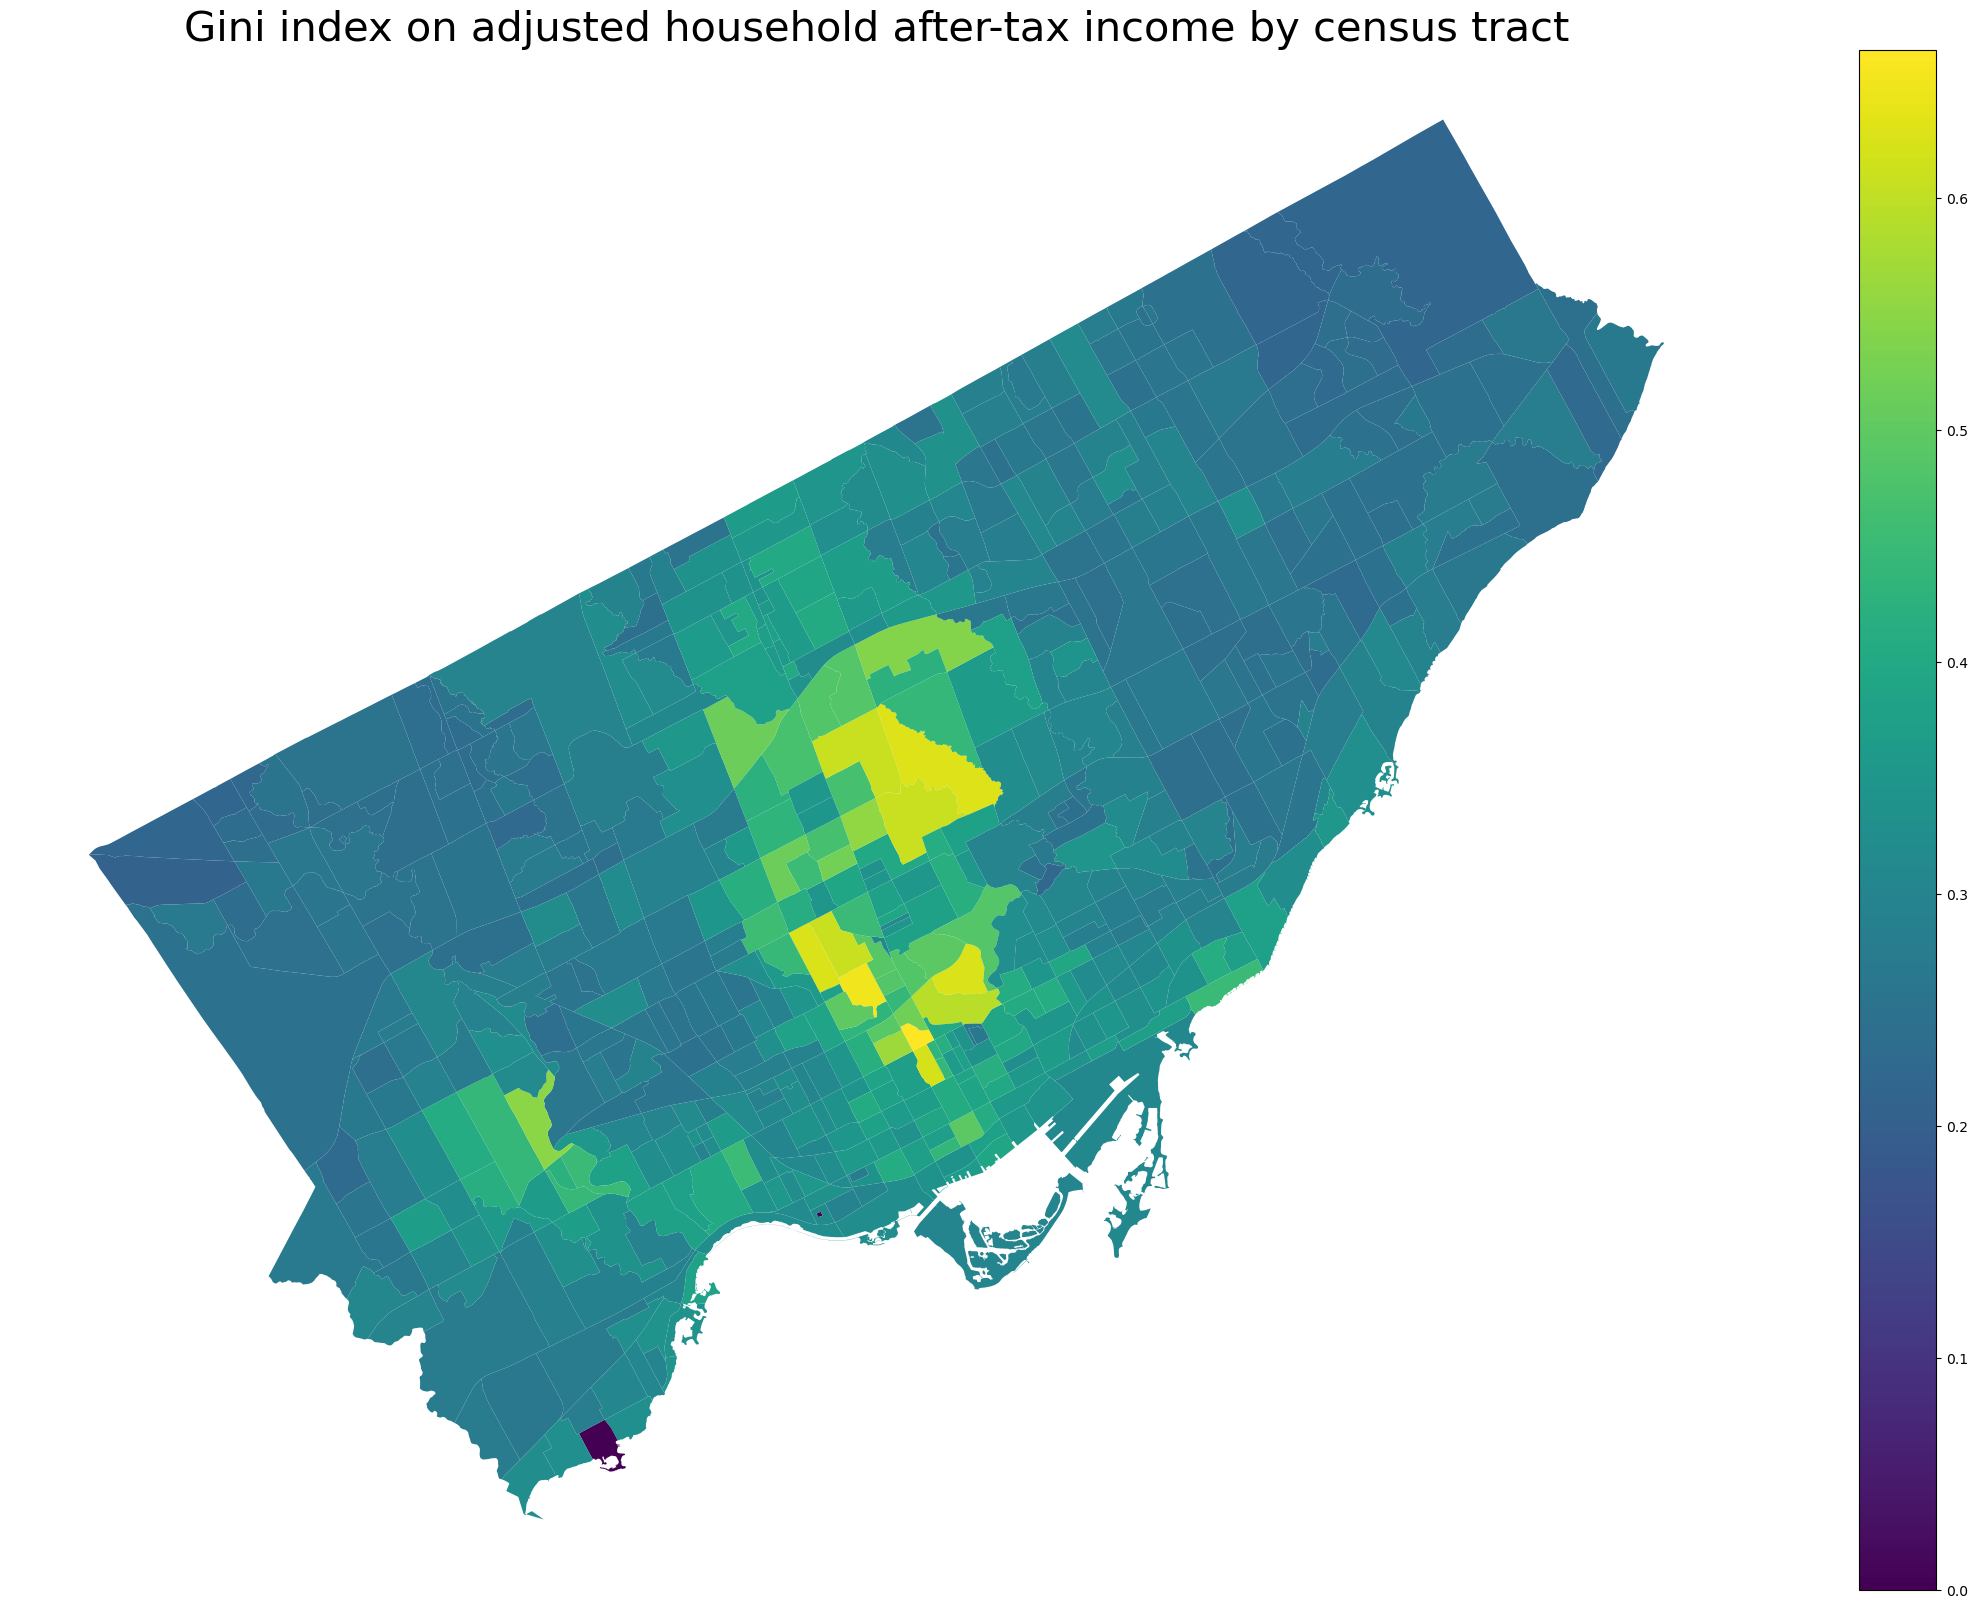

In [44]:
simple_plot('gini_after_tax')

If you want to change the color scheme of the map, you can choose the "color map" of the plot by adding in the optional `cmap` argument to `plot()`. You can choose from the variety of color maps available in the `matplotlib` package, which is what our plotting software is built off of. Above, we saw the default colormap, which is called viridis. If you want to view all the available colormaps, you can reference the documentation [here](https://matplotlib.org/users/colormaps.html).

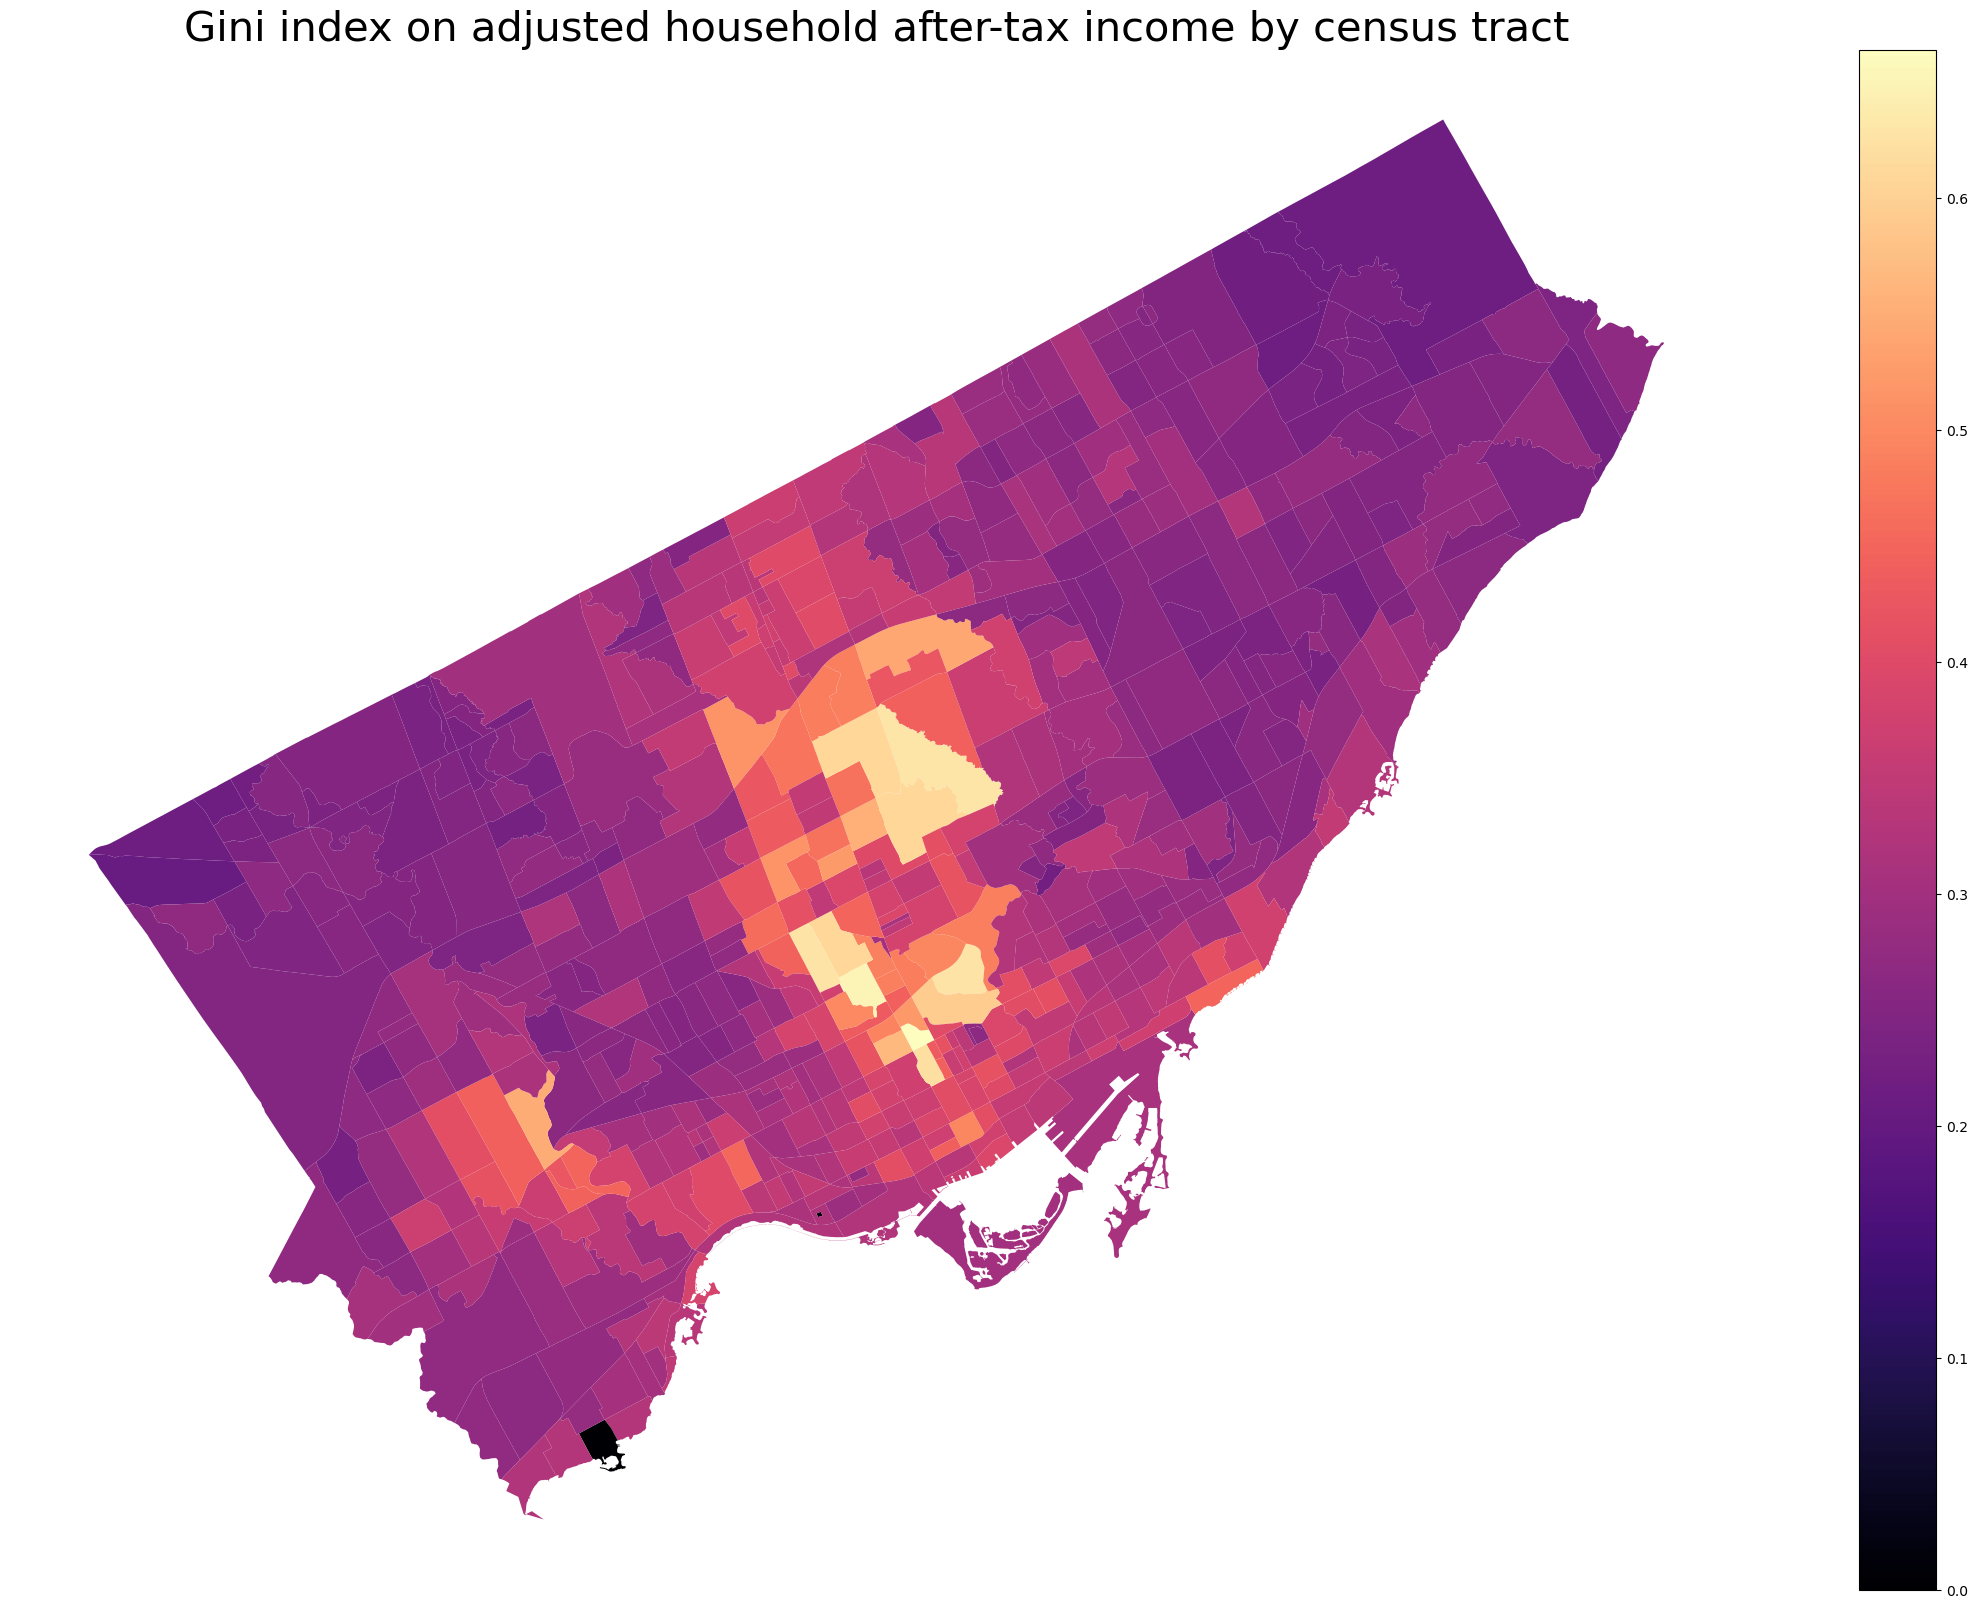

In [45]:
toronto.plot(column = 'gini_after_tax', legend = True, cmap = 'magma')
plt.title(plot_titles['gini_after_tax'], fontsize = 30)
plt.axis('off');

Now it's your turn! In the following cell, try creating your own choropleth map using a different column from `toronto_gpd`. If you want to see all of the columns in our data, you can scroll up to where we displayed all of the column names.

<font color = 'red'>

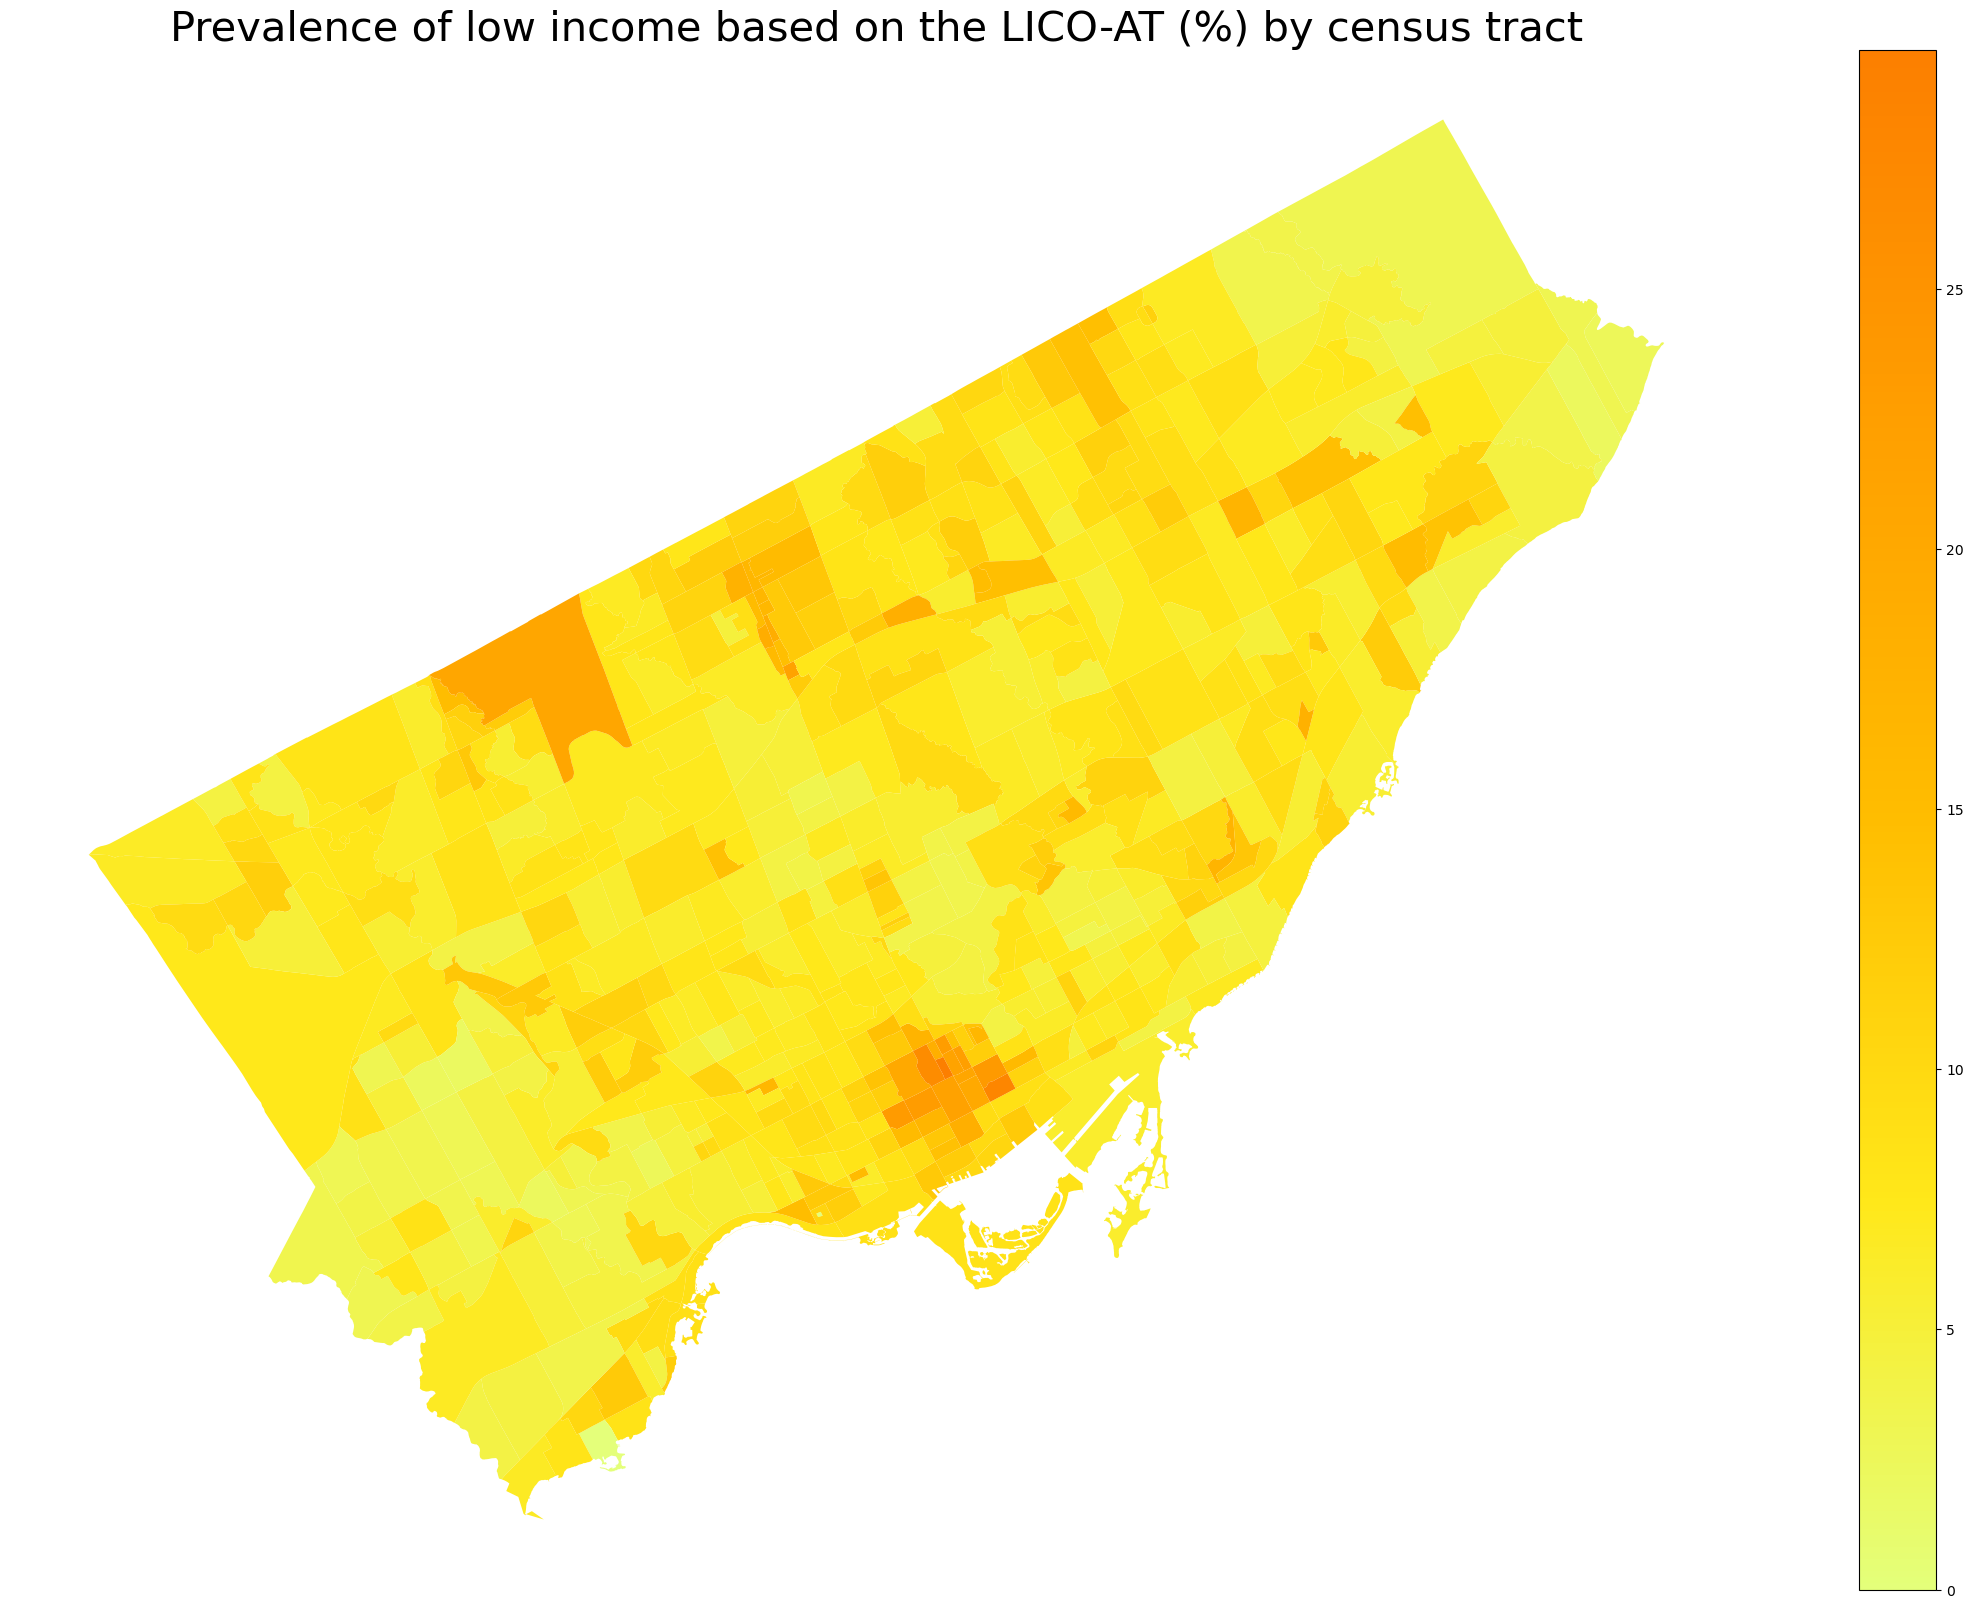

In [47]:
# YOUR CODE HERE
toronto.plot(column = 'lico_at', legend = True, cmap = 'Wistia')
plt.title(plot_titles['lico_at'], fontsize = 30)
plt.axis('off');

What are some conclusions that you can draw from the map you created?

YOUR ANSWER HERE

## Coordinate Reference Systems (CRS)

Statistics Canada uses a special Coordinate Reference System called [Statistics Canada Lambert](https://epsg.io/3347) (EPSG:3347) for its shapefiles. You can read Statistics Canada's Illustrated Glossary page, including why this projection is used for most statistical analysis of Canadian geographies [here](https://www150.statcan.gc.ca/n1/pub/92-195-x/2021001/other-autre/coord/coord-eng.htm). 


A standard CRS used internationally for a variety of catography and satellite navigateion is the World Geodetic System. The Map and Data Library has several Toronto-centric datasets- pay special attention to their projection before working with them. The EPSG values are shortened abbreviations of the coordinate system names that can be used to easily convert between projections using geospatial software/libraries. You can read more about EPSG [here](https://epsg.org/home.html).

In [142]:
toronto.crs

<Derived Projected CRS: EPSG:3347>
Name: NAD83 / Statistics Canada Lambert
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - onshore and offshore - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon.
- bounds: (-141.01, 38.21, -40.73, 86.46)
Coordinate Operation:
- name: Statistics Canada Lambert
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [145]:
# reprojects coordinates to new coordinate reference system
toronto = toronto.to_crs(4326)

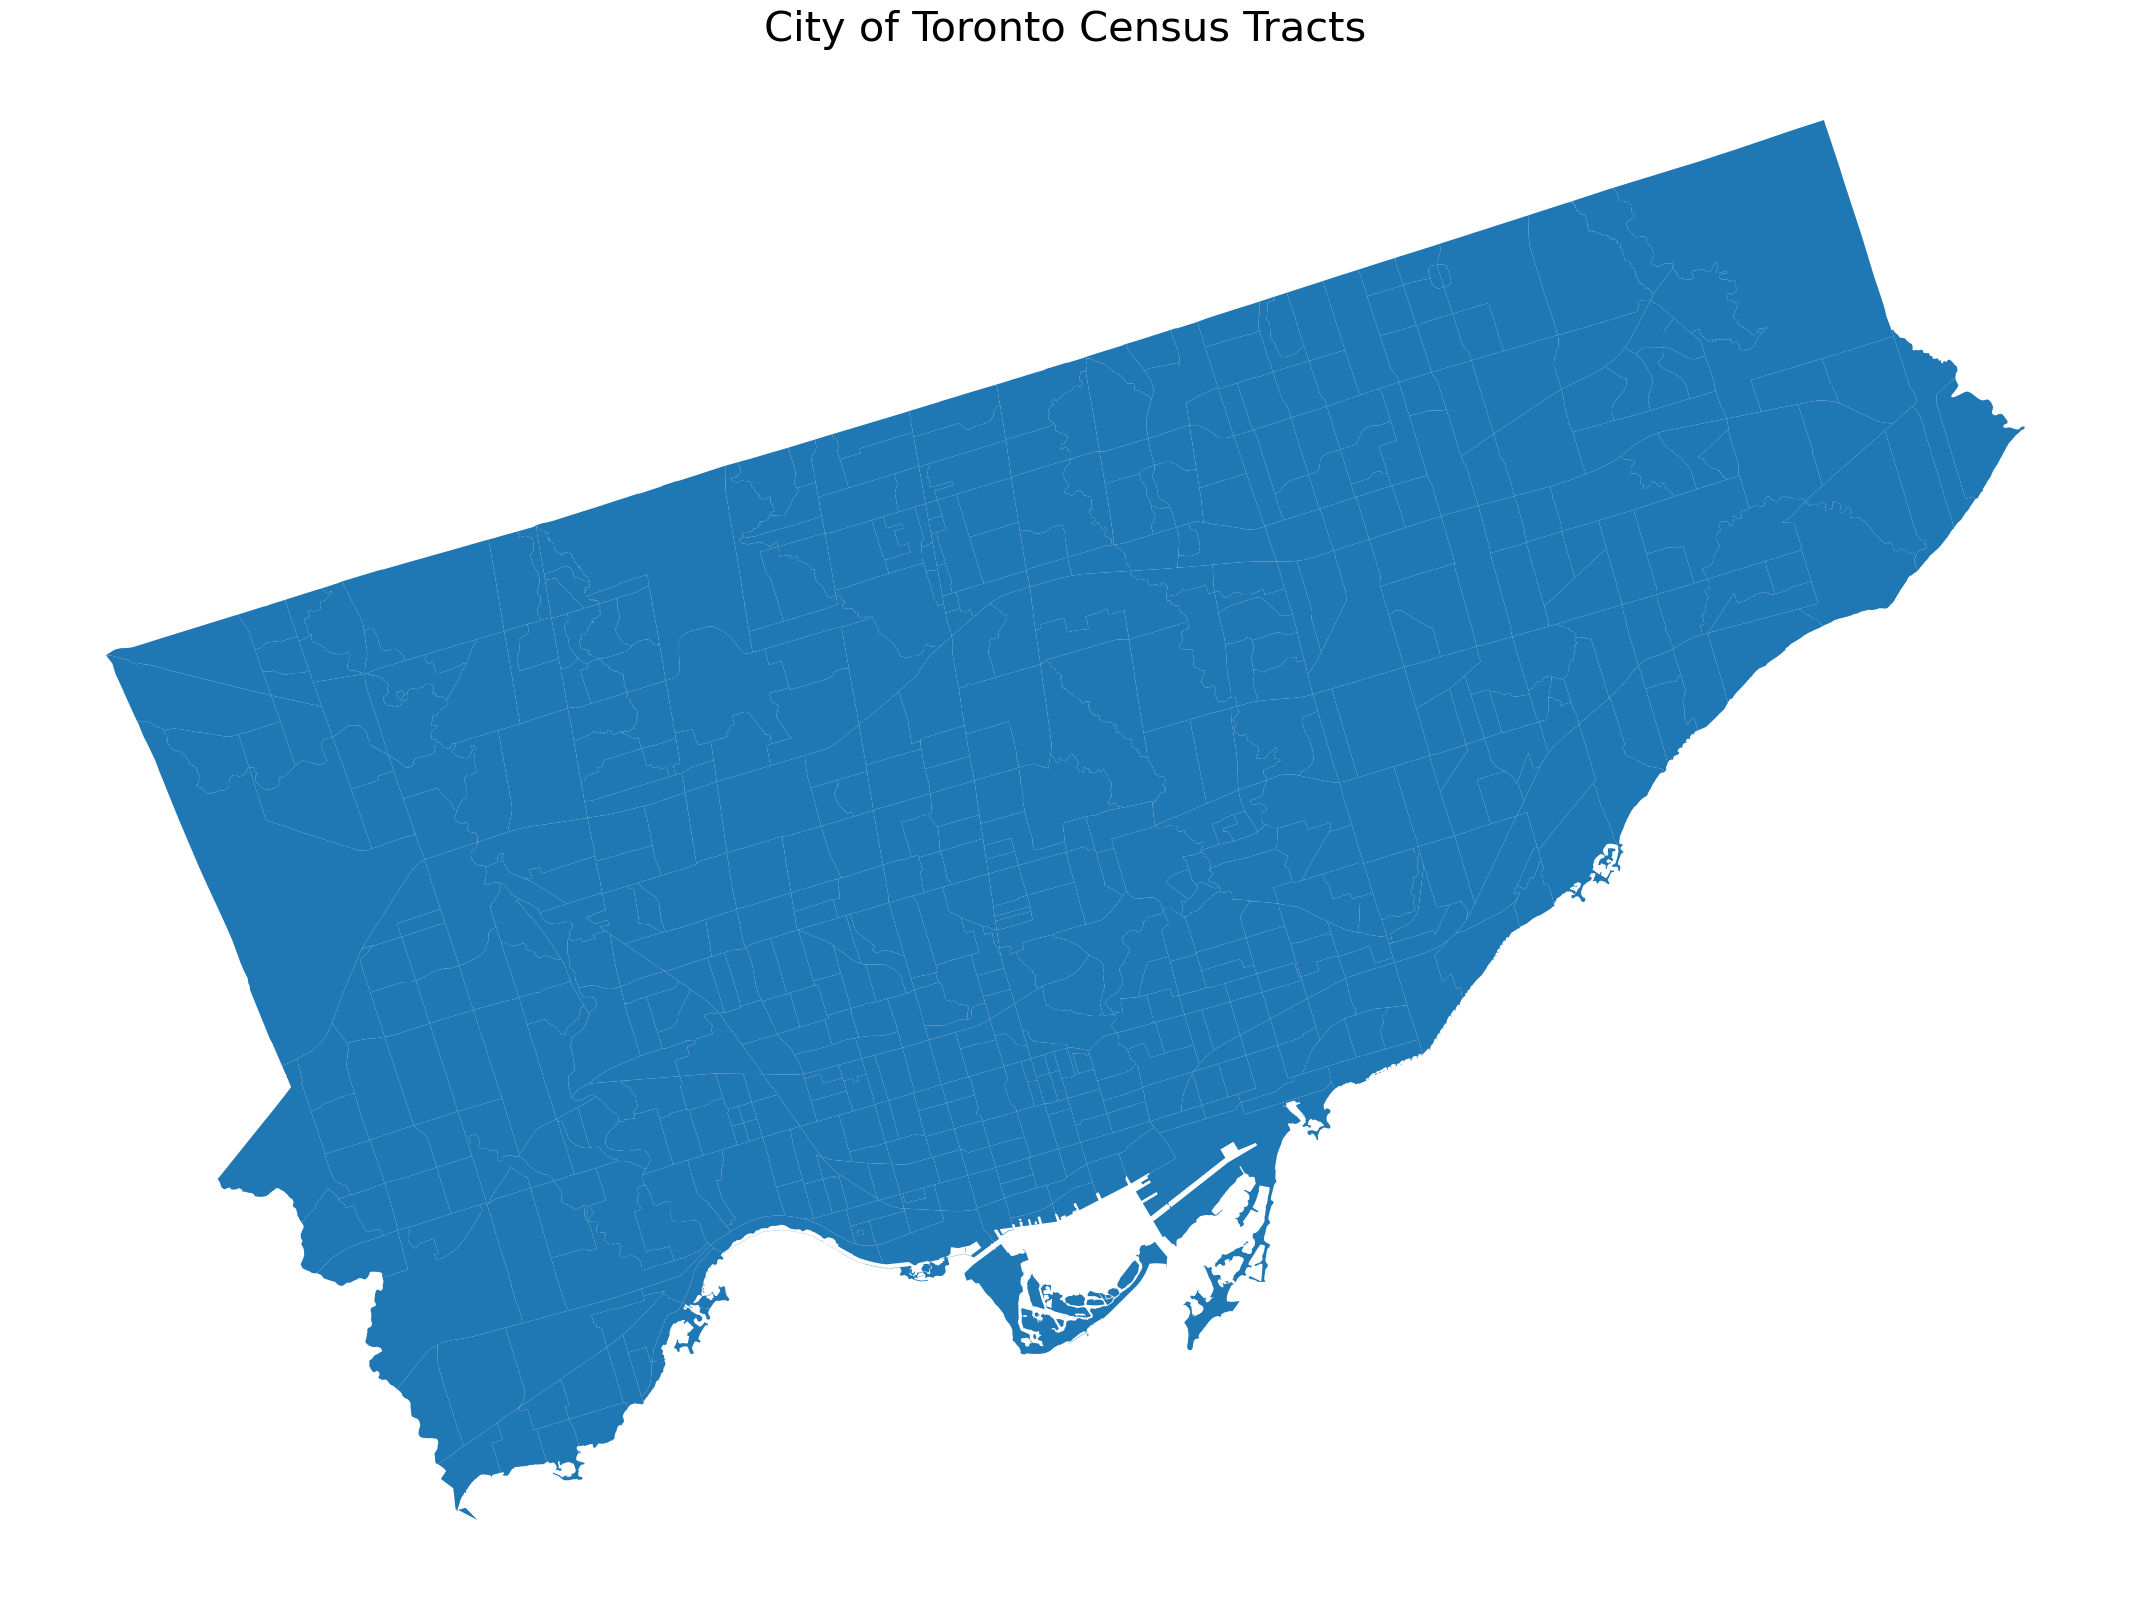

In [147]:
toronto.plot()
plt.title('City of Toronto Census Tracts', fontsize = 30)
plt.axis('off');

# More geospatial data types in `geopandas`

So far, we have only been creating maps using polygons, but `geopandas` has a few more data types we can work with. First, we need some new data to work with. In the `ttc` folder, we have folders named `bart_stations` and `bart_routes` containing geospatial data about the BART system. Load in the data as we did with `alameda` file from the beginning of the lab.

### Working with GTFS data


In [48]:
""" Utility functions for GGR337 CKAN API lab.

These functions have been adapted from Data 100 course materials.
"""

def retrieve_package(keys):
    """Downloads package info of a dataset using CKAN's API

    Args:
        keys (dict): A Python dictionary with Toronto Open Dataset id 
          keys (strings), like this (but filled in):
            {
                "id": "<dataset id here>",
            }

    Returns:
        list: A list of Dictonary objects, each representing help, response, and result."""
    import requests
    # Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
    # https://docs.ckan.org/en/latest/api/
    base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
    # Datasets are called "packages". Each package can contain many "resources"
    # To retrieve the metadata for this package and its resources, use the package name in this page's URL:
    url = base_url + "/api/3/action/package_show"
    package = requests.get(url, params = keys).json()
    return package


def load_tpl_events(method):
    """Loads the dataframe of the toronto public library events feeding using the predownloaded csv or API request
    
    Args:
        method (string): can either be 'read_csv' for predownloaded csv or 'API' for API request
        """
        
    if method == "read_csv":
        return pd.read_csv("tpl-events-feed.csv")
    elif method == "API":
        
        package = retrieve_package("library-branch-programs-and-events-feed")
        
        
        for idx, resource in enumerate(package["result"]["resources"]):
            if resource["datastore_active"]:
                # to get all records in CSV format
                url = base_url + "/datastore/dump/" + resource["id"]
                # do a GET request on the url and access its text attribute
                resource_dump_data = requests.get(url).text
                # read the raw csv text into a pandas dataframe to work with it
                return pd.read_csv(StringIO(resource_dump_data), sep=",")
    else:
        print("Unacceptable argument for 'method'. Use either 'read_csv' or 'API'.")
        return
              
def load_public_survey(method):
    """Loads the dataframe of the toronto public survey results using the predownloaded csv or API request
    
    Args:
        method (string): can either be 'read_csv' for predownloaded csv or 'API' for API request
        """
        
    if method == "read_csv":
        return pd.read_csv("torr-public-survey-results.csv")
    elif method == "API":
        
        package = retrieve_package({ "id": "toronto-office-of-recovery-and-rebuild-public-survey-results"})
        
        for idx, resource in enumerate(package["result"]["resources"]):
           # To get metadata for non datastore_active resources:
            if resource["format"] == "CSV":
                url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
                resource_data = requests.get(url).json()
                # do a GET request on the url and access its text attribute
                resource_dump_data = requests.get(resource_data['result']['url']).text
                # read the raw csv text into a pandas dataframe to work with it
                return pd.read_csv(StringIO(resource_dump_data), sep=",")
    else:
        print("Unacceptable argument for 'method'. Use either 'read_csv' or 'API'.")
        return

In [40]:
# https://open.toronto.ca/dataset/ttc-routes-and-schedules/
# https://open.toronto.ca/dataset/major-city-wide-cycling-routes/

ttc_routes_package = retrieve_package({"id":"ttc-routes-and-schedules"})
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
for idx, resource in enumerate(ttc_routes_package["result"]["resources"]):
    # To get metadata for non datastore_active resources:
    if not resource["datastore_active"]:
        url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
        resource_data = requests.get(url).json()
zipurl = resource_data['result']['url']
zipresp = urlopen(zipurl)
# Create a new file on the hard drive
tempzip = open("ttc/tempfile.zip", "wb")
tempzip.write(zipresp.read())
# Close the newly-created file
tempzip.close()

In [149]:
# a lot is going on here, but it is just reading in the contents of the zipped file to dataframes
# adapted from: https://max-coding.medium.com/how-to-process-gtfs-data-using-pandas-geopandas-4b34f2ad3273

with ZipFile("ttc/routes_schedules.zip") as myzip:
    shapes_df = pd.read_csv(myzip.open("shapes.txt"), dtype={
        'shape_id': 'str', 
        'shape_pt_lat': 'float', 
        'shape_pt_lon': 'float',  
        'shape_pt_sequence': 'Int64', 
        'shape_dist_traveled': 'float'
    })
    shapes_gdf = gpd.GeoDataFrame(shapes_df, 
        geometry=gpd.points_from_xy(shapes_df.shape_pt_lon, shapes_df.shape_pt_lat)).set_crs(epsg=4326)
    
    stops_df = pd.read_csv(myzip.open("stops.txt"), dtype={
        'stop_id': 'str', 
        'stop_code': 'str',
        'stop_name': 'str',
        'stop_lat': 'float',
        'stop_lon': 'float'
    })
    stops_gdf = gpd.GeoDataFrame(stops_df, 
        geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)).set_crs(epsg=4326)
    
    routes_df = pd.read_csv(myzip.open("routes.txt"), dtype={
        'route_id': 'str',  
        'agency_id': 'str',  
        'route_short_name': 'str',  
        'route_long_name': 'str', 
        'route_desc': 'str', 
        'route_type': 'Int64',
        'route_color': 'str',  
        'route_text_color': 'str'
    })
    
    trips_df = pd.read_csv(myzip.open("trips.txt"), dtype={
        'route_id': 'str', 
        'service_id': 'str',  
        'trip_id': 'str',
        'shape_id': 'str', 
        'trip_headsign': 'str', 
        'direction_id': 'str',  
        'block_id': 'str', 
        'wheelchair_accessible': 'str', 
        'bikes_allowed': 'str'
    })
    
    calendar_df = pd.read_csv(myzip.open("calendar.txt"), dtype={
        'service_id': 'str',  
        'monday': 'bool',  
        'tuesday': 'bool',  
        'wednesday': 'bool',  
        'thursday': 'bool',  
        'friday': 'bool', 
        'saturday': 'bool',  
        'sunday': 'bool',  
        'start_date': 'str', 
        'end_date': 'str',
    })
    
    calendar_dates_df = pd.read_csv(myzip.open("calendar_dates.txt"), dtype={
        'service_id': 'str',  
        'date': 'str',
        'exception_type': 'Int64',
    })
    

In [150]:
shapes_df.head()

shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence  \
0   982139     43.789038    -79.330471                  1   
1   982139     43.789244    -79.329574                  2   
2   982139     43.787992    -79.328993                  3   
3   982139     43.785857    -79.327985                  4   
4   982139     43.785722    -79.327921                  5   

   shape_dist_traveled                    geometry  
0               0.0000  POINT (-79.33047 43.78904)  
1               0.0756  POINT (-79.32957 43.78924)  
2               0.2233  POINT (-79.32899 43.78799)  
3               0.4747  POINT (-79.32798 43.78586)  
4               0.4905  POINT (-79.32792 43.78572)

In [151]:
segments_df.head()

shape_id  start_lat  start_lng seq    end_lat    end_lng
1   982139  43.789038 -79.330471   1  43.789244 -79.329574
2   982139  43.789244 -79.329574   2  43.787992 -79.328993
3   982139  43.787992 -79.328993   3  43.785857 -79.327985
4   982139  43.785857 -79.327985   4  43.785722 -79.327921
5   982139  43.785722 -79.327921   5  43.785436 -79.329186

In [152]:
stops_df.head()

stop_id stop_code                       stop_name  stop_desc   stop_lat  \
0     262       662       Danforth Rd at Kennedy Rd        NaN  43.714379   
1     263       929      Davenport Rd at Bedford Rd        NaN  43.674448   
2     264       940       Davenport Rd at Dupont St        NaN  43.675511   
3     265      1871  Davisville Ave at Cleveland St        NaN  43.702088   
4     266     11700          Disco Rd at Attwell Dr        NaN  43.701362   

    stop_lon  zone_id  stop_url  location_type  parent_station  stop_timezone  \
0 -79.260939      NaN       NaN            NaN             NaN            NaN   
1 -79.399659      NaN       NaN            NaN             NaN            NaN   
2 -79.401938      NaN       NaN            NaN             NaN            NaN   
3 -79.378112      NaN       NaN            NaN             NaN            NaN   
4 -79.594843      NaN       NaN            NaN             NaN            NaN   

   wheelchair_boarding                    geometry  
0                    1  POINT (-79.26094 43.71438)  
1                    1  POINT (-79.39966 43.67445)  
2                    2  POINT (-79.40194 43.67551)  
3                    1  POINT (-79.37811 43.70209)  
4                    1  POINT (-79.59484 43.70136)

In [153]:
routes_df.head()

route_id agency_id route_short_name            route_long_name route_desc  \
0    70223         1                1  LINE 1 (YONGE-UNIVERSITY)        NaN   
1    70006         1               10                  VAN HORNE        NaN   
2    70007         1              100            FLEMINGDON PARK        NaN   
3    70008         1              101             DOWNSVIEW PARK        NaN   
4    70009         1              102                MARKHAM RD.        NaN   

   route_type  route_url route_color route_text_color  
0           1        NaN      D5C82B           000000  
1           3        NaN      FF0000           FFFFFF  
2           3        NaN      FF0000           FFFFFF  
3           3        NaN      FF0000           FFFFFF  
4           3        NaN      FF0000           FFFFFF

In [154]:
trips_df.head()

route_id service_id   trip_id                              trip_headsign  \
0    70006          1  46272627  EAST - 10 VAN HORNE towards VICTORIA PARK   
1    70006          1  46272628  EAST - 10 VAN HORNE towards VICTORIA PARK   
2    70006          1  46272634  EAST - 10 VAN HORNE towards VICTORIA PARK   
3    70006          1  46272633  EAST - 10 VAN HORNE towards VICTORIA PARK   
4    70006          1  46272632  EAST - 10 VAN HORNE towards VICTORIA PARK   

  trip_short_name direction_id block_id shape_id wheelchair_accessible  \
0             NaN            0  2006639   982139                     1   
1             NaN            0  2006639   982140                     1   
2             NaN            0  2006639   982140                     1   
3             NaN            0  2006639   982140                     1   
4             NaN            0  2006639   982140                     1   

  bikes_allowed  
0             1  
1             1  
2             1  
3             1  
4             1

In [155]:
trips_df.groupby('service_id').size().sort_values(ascending = False)

service_id
1       38915
2       31934
4       29964
3       28269
401       142
4501       16
4401       14
501        12
2901        9
dtype: int64

In [89]:
calendar_df

service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0          1    True     True       True      True    True     False   False   
1          2   False    False      False     False   False      True   False   
2          3   False    False      False     False   False     False    True   
3          4   False    False      False     False   False     False   False   
4        401   False    False      False     False   False     False   False   
5        501   False    False      False     False   False     False   False   
6       2901   False    False      False     False   False     False   False   
7       4401   False    False      False     False   False     False   False   
8       4501   False    False      False     False   False     False   False   

  start_date  end_date  
0   20231008  20231118  
1   20231008  20231118  
2   20231008  20231118  
3   20231008  20231118  
4   20231008  20231118  
5   20231008  20231118  
6   20231008  20231118  
7   20231008  20231118  
8   20231008  20231118

From this table, we can see that there are 9 lines in the Toronto TTC file and quite a few of them haven't run over the period for which we have data. `service_id == 1` runs weekdays, `service_id == 2` runs Saturdays, and `service_id == 3` runs Sundays.

In [156]:
calendar_dates_df

service_id      date  exception_type
0           4  20231009               1
1           1  20231009               2
2         401  20231010               1
3         501  20231010               1
4        4501  20231010               1
..        ...       ...             ...
84        501  20231116               1
85       4401  20231116               1
86        401  20231117               1
87        501  20231117               1
88       4501  20231117               1

[89 rows x 3 columns]

In [157]:
calendar_dates_df.groupby(['service_id', 'exception_type']).size().sort_values(ascending = False)

service_id  exception_type
401         1                 29
501         1                 29
4401        1                 17
4501        1                 12
1           2                  1
4           1                  1
dtype: int64

These dataframes are quite large and plotting maps of them can get quite messy, so let's pick one day of the week to focus on. You can change this to select any day of the week that you want, just be sure to type it in `lowercase`. 

In [158]:
# defaults to whatever day of the week it is when you run this cell, but you can manually change it to whatever you like!
day_of_week_name = dt.datetime.today().strftime('%A').lower()
day_of_week_name

'thursday'

In [159]:
services_for_day = calendar_df[(calendar_df[day_of_week_name])].service_id.to_numpy()

In [160]:
services_for_day

array(['1'], dtype=object)

In [161]:
calendar_dates_df['as_datetime'] = pd.to_datetime(calendar_dates_df['date'])
calendar_dates_df[calendar_dates_df['as_datetime'].dt.strftime('%A').str.lower() == day_of_week_name]

service_id      date  exception_type as_datetime
8         401  20231012               1  2023-10-12
9         501  20231012               1  2023-10-12
10       4401  20231012               1  2023-10-12
23        401  20231019               1  2023-10-19
24        501  20231019               1  2023-10-19
25       4401  20231019               1  2023-10-19
38        401  20231026               1  2023-10-26
39        501  20231026               1  2023-10-26
40       4401  20231026               1  2023-10-26
53        401  20231102               1  2023-11-02
54        501  20231102               1  2023-11-02
55       4401  20231102               1  2023-11-02
68        401  20231109               1  2023-11-09
69        501  20231109               1  2023-11-09
70       4401  20231109               1  2023-11-09
83        401  20231116               1  2023-11-16
84        501  20231116               1  2023-11-16
85       4401  20231116               1  2023-11-16

In [162]:
coords = shapes_df[["shape_pt_lat", "shape_pt_lon", "shape_pt_sequence"]]
coords_roll_1 = np.roll(coords, 1, axis=0)
segments = pd.DataFrame(np.concatenate([coords_roll_1, coords], axis=1), columns=["start_lat", "start_lng", "start_seq", "end_lat", "end_lng", "end_seq"])
segments_df = shapes_df[["shape_id"]].join(segments)
segments_df = segments_df[segments_df.end_seq != 1]
segments_df = segments_df.drop(columns=['end_seq']).rename(columns={ "start_seq": "seq" })
segments_df.head()

shape_id  start_lat  start_lng seq    end_lat    end_lng
1   982139  43.789038 -79.330471   1  43.789244 -79.329574
2   982139  43.789244 -79.329574   2  43.787992 -79.328993
3   982139  43.787992 -79.328993   3  43.785857 -79.327985
4   982139  43.785857 -79.327985   4  43.785722 -79.327921
5   982139  43.785722 -79.327921   5  43.785436 -79.329186

In [163]:
routes_df.head()

route_id agency_id route_short_name            route_long_name route_desc  \
0    70223         1                1  LINE 1 (YONGE-UNIVERSITY)        NaN   
1    70006         1               10                  VAN HORNE        NaN   
2    70007         1              100            FLEMINGDON PARK        NaN   
3    70008         1              101             DOWNSVIEW PARK        NaN   
4    70009         1              102                MARKHAM RD.        NaN   

   route_type  route_url route_color route_text_color  
0           1        NaN      D5C82B           000000  
1           3        NaN      FF0000           FFFFFF  
2           3        NaN      FF0000           FFFFFF  
3           3        NaN      FF0000           FFFFFF  
4           3        NaN      FF0000           FFFFFF

In [164]:
shape_trips = trips_df.groupby(by="shape_id").size().to_frame("tot_trips")
shape_trips.head()

tot_trips
shape_id           
982139            1
982140           18
982141           19
982146          632
982149          623

In [165]:
shape_trips[shape_trips.index == "982620"]

tot_trips
shape_id           
982620            3

In [167]:
toronto.bounds

minx       miny       maxx       maxy
43   -79.396459  43.695654 -79.386265  43.699298
44   -79.254796  43.772076 -79.241748  43.783143
45   -79.245045  43.774327 -79.211132  43.789217
46   -79.277388  43.789066 -79.260430  43.808019
47   -79.266493  43.793490 -79.241901  43.813047
...         ...        ...        ...        ...
1212 -79.481875  43.620897 -79.469140  43.632895
1213 -79.394133  43.659817 -79.385842  43.669661
1214 -79.387712  43.660809 -79.383093  43.666057
1215 -79.362722  43.645604 -79.347269  43.656649
1216 -79.371447  43.642600 -79.360201  43.651561

[585 rows x 4 columns]

In [168]:
def limit_to_bounding_box(gdf, bounding_box):
    return gdf.cx[bounding_box["west"]:bounding_box["east"],bounding_box["south"]:bounding_box["north"]]# City of Toronto bounding box


toronto_bb = {
    "north": max(toronto.bounds['maxy']),
    "south": min(toronto.bounds['miny']),
    "west": max(toronto.bounds['maxx']),
    "east": min(toronto.bounds['minx']),
}

In [169]:
# how many trip occurs in each segment per day
shape_segments_trips = pd.merge(segments_df, shape_trips, left_on="shape_id", right_index=True)
segment_trips = shape_segments_trips.groupby(by=["start_lat", "start_lng", "end_lat", "end_lng"]).sum("tot_trips").reset_index()
segment_trips.head()

start_lat  start_lng    end_lat    end_lng  tot_trips
0  43.591495 -79.544511  43.591511 -79.544427         56
1  43.591508 -79.544592  43.591495 -79.544511         56
2  43.591511 -79.544427  43.591567 -79.544350         60
3  43.591543 -79.544658  43.591508 -79.544592         56
4  43.591567 -79.544350  43.591634 -79.544309        108

In [170]:
from shapely.geometry import Point
from shapely.geometry import LineString

segment_trips['start_point'] = segment_trips.apply(lambda row: Point(row['start_lng'], row['start_lat']), axis = 1)
segment_trips['end_point'] = segment_trips.apply(lambda row: Point(row['end_lng'], row['end_lat']), axis = 1)

segment_trips['geometry'] = segment_trips.apply(lambda row: LineString([row['start_point'], row['end_point']]), axis = 1)

segment_trips.head()

start_lat  start_lng    end_lat    end_lng  tot_trips  \
0  43.591495 -79.544511  43.591511 -79.544427         56   
1  43.591508 -79.544592  43.591495 -79.544511         56   
2  43.591511 -79.544427  43.591567 -79.544350         60   
3  43.591543 -79.544658  43.591508 -79.544592         56   
4  43.591567 -79.544350  43.591634 -79.544309        108   

                    start_point                     end_point  \
0  POINT (-79.544511 43.591495)  POINT (-79.544427 43.591511)   
1  POINT (-79.544592 43.591508)  POINT (-79.544511 43.591495)   
2  POINT (-79.544427 43.591511)   POINT (-79.54435 43.591567)   
3  POINT (-79.544658 43.591543)  POINT (-79.544592 43.591508)   
4   POINT (-79.54435 43.591567)  POINT (-79.544309 43.591634)   

                                            geometry  
0  LINESTRING (-79.544511 43.591495, -79.544427 4...  
1  LINESTRING (-79.544592 43.591508, -79.544511 4...  
2  LINESTRING (-79.544427 43.591511, -79.54435 43...  
3  LINESTRING (-79.544658 43.591543, -79.544592 4...  
4  LINESTRING (-79.54435 43.591567, -79.544309 43...

In [171]:
segment_trips_gpd = limit_to_bounding_box(gpd.GeoDataFrame(segment_trips), toronto_bb)
segment_trips_gpd.head()

start_lat  start_lng    end_lat    end_lng  tot_trips  \
0  43.591495 -79.544511  43.591511 -79.544427         56   
1  43.591508 -79.544592  43.591495 -79.544511         56   
2  43.591511 -79.544427  43.591567 -79.544350         60   
3  43.591543 -79.544658  43.591508 -79.544592         56   
4  43.591567 -79.544350  43.591634 -79.544309        108   

                    start_point                     end_point  \
0  POINT (-79.544511 43.591495)  POINT (-79.544427 43.591511)   
1  POINT (-79.544592 43.591508)  POINT (-79.544511 43.591495)   
2  POINT (-79.544427 43.591511)   POINT (-79.54435 43.591567)   
3  POINT (-79.544658 43.591543)  POINT (-79.544592 43.591508)   
4   POINT (-79.54435 43.591567)  POINT (-79.544309 43.591634)   

                                            geometry  
0  LINESTRING (-79.54451 43.59150, -79.54443 43.5...  
1  LINESTRING (-79.54459 43.59151, -79.54451 43.5...  
2  LINESTRING (-79.54443 43.59151, -79.54435 43.5...  
3  LINESTRING (-79.54466 43.59154, -79.54459 43.5...  
4  LINESTRING (-79.54435 43.59157, -79.54431 43.5...

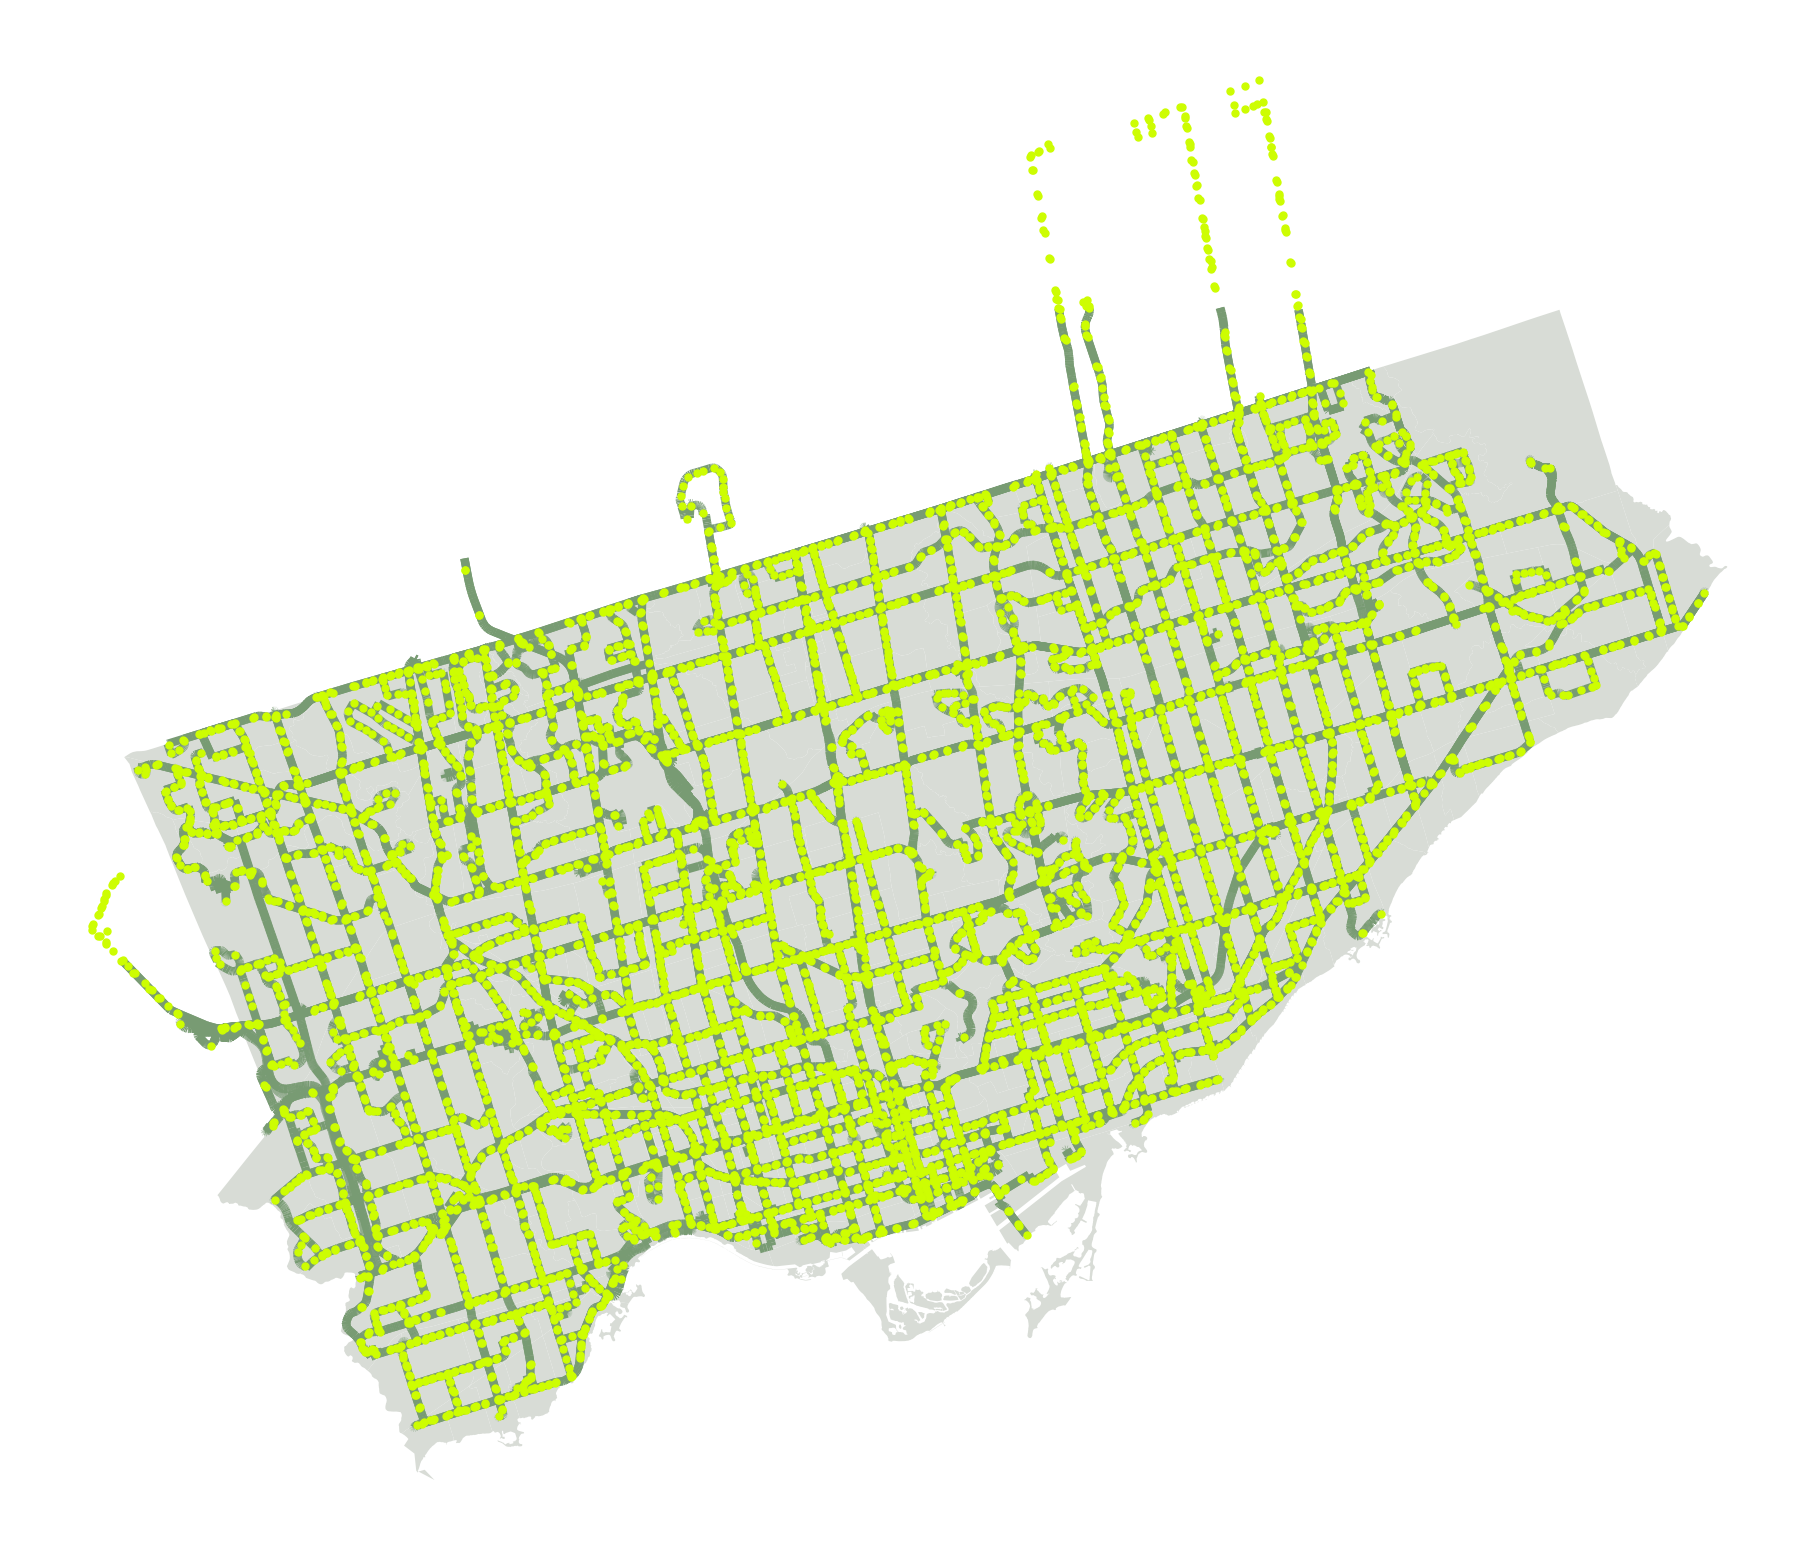

In [174]:
base = toronto.plot(color = '#d8dcd6', zorder=1)
segment_trips_gpd.plot(ax=base, color = '#789b73', linewidth = 6, zorder=2)
stops_gdf.plot(ax=base, color = '#cdfd02', markersize = 25, zorder=3)
plt.axis('off');

In [ ]:
fig = plt.figure(figsize=(30,21))
ax = plt.axes()
ax.set(facecolor = "black")
segments_df.plot(ax=ax, legend=True)

## Examining the data

To get an idea of what the data we are working with looks like, let's call the `.head()` method on the data we have just read.

In [ ]:
bart_stations.head()

In [ ]:
bart_routes.head()

Looking at the `geometry` columns of our two GeoDataFrames, we can see that we have some new types of data. Where we had polygons before, our new data have points and linestrings. Points are are exactly what they sound like, 1-dimensional coordinates in space. Linestrings are line segments that do not necessarily have to be a straight line.

Use the following cell to draw a linestring the same way we did the first time we looked at a polygon.

In [ ]:
# YOUR CODE HERE
bart_routes.loc[0, 'geometry']

## Creating the map

In the next few cells, you will create a map that overlays the bart stations and routes over a map of all the counties. (Alameda, Contra Costa, and San Francisco)

First, we need the base map of all the counties. We can use the aggregated `GeoDataFrame` we created earlier in this notebook. Try setting the `color` and `edgecolor` arguments so the map looks more uniform.

In [ ]:
base = data.plot()
plt.axis('off');

Next, overlay the routes and stations and plot the graph by using this as the base for the map. The Jupyter notebook will not remember the map you drew in the previous cell even if you assigned it a name, so make sure to plot the base map again in the following cell.

In [ ]:
base = data.plot(color = '#d8dcd6', zorder=1)
bart_routes.plot(ax=base, color = '#789b73', linewidth = 6, zorder=2)
bart_stations.plot(ax=base, color = '#cdfd02', markersize = 150, zorder=3)
plt.axis('off');

In [ ]:
base = data.plot(color = '#d8dcd6', zorder=1)
bart_routes.plot(ax=base, color = '#789b73', linewidth = 6, zorder=2)
bart_stations.plot(ax=base, color = '#cdfd02', markersize = 150, zorder=3)
plt.xlim(-122.53, -122.10)
plt.ylim(37.71, 37.91)

plt.axis('on');

Congratulations! You're done with this lab! If you are interested in learning more about what you can do with `geopandas`, you can find the documentation for the package [here](http://geopandas.org/reference.html).

***

### Adapted from Berkeley lab content created by Monica Wilkinson and Vera Wang
### References:
- http://geopandas.org/mapping.html
- https://matplotlib.org/users/colormaps.html